# CF969: Big-Data for Computational Finance

# Assignment 2

# Predicting Default for Borrowers

### Prepared by: Ashwin Purushothama Dhas (ap23710@essex.ac.uk)(2320993)

# --***Imports***--

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Input,Dense,BatchNormalization,Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall, AUC
from sklearn.metrics import f1_score
from keras.regularizers import l2
from keras.regularizers import l1

# --***Data Preprocessing***--

## Load and View Data

In [2]:
# Mounting Google Drive and Setting File Paths for Data Analysis

drive.mount('/content/drive')

train_file_path = '/content/drive/My Drive/CF969-24-SU/Assignment 2/data/trainData.csv'
test_file_path = '/content/drive/My Drive/CF969-24-SU/Assignment 2/data/testData.csv'
var_desc_file_path = '/content/drive/My Drive/CF969-24-SU/Assignment 2/data/varDescription.csv'

Mounted at /content/drive


In [3]:
# Loading Training and Testing Data from CSV Files

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

In [4]:
# Displaying the First Few Rows of the Training Data

train_data.head()

,id,member_id,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,NaN,NaN,18600,10.99,608.86,B,6 years,RENT,80000.0,Fully Paid,...,0.0,0.0,0.0,15705.09,0.0,Individual,0.0,0.0,170238.0,20700.0
1,NaN,NaN,2000,17.97,72.28,D,4 years,MORTGAGE,55400.0,Current,...,0.0,0.0,0.0,72.28,0.0,Joint App,0.0,74.0,351452.0,10800.0
2,NaN,NaN,12000,12.29,400.24,C,10+ years,OWN,60000.0,Fully Paid,...,0.0,0.0,0.0,11281.15,0.0,Individual,0.0,0.0,18207.0,20600.0
3,NaN,NaN,16000,19.42,589.90,D,7 years,RENT,64000.0,Current,...,0.0,0.0,0.0,589.90,0.0,Individual,0.0,0.0,12293.0,7800.0
4,NaN,NaN,22525,16.02,548.01,C,10+ years,MORTGAGE,94080.0,Fully Paid,...,0.0,0.0,0.0,21483.11,0.0,Individual,0.0,250.0,571244.0,53800.0


In [5]:
# Displaying the First Few Rows of the Test Data

test_data.head()

,id,member_id,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,NaN,NaN,8000,7.07,247.28,A,10+ years,MORTGAGE,78000.0,Fully Paid,...,0.0,0.0,0.0,6844.48,0.0,Individual,0.0,0.0,200412.0,16800.0
1,NaN,NaN,20000,7.21,619.47,A,3 years,RENT,78000.0,Current,...,0.0,0.0,0.0,619.47,0.0,Individual,0.0,0.0,39187.0,42100.0
2,NaN,NaN,20000,12.74,452.41,C,5 years,MORTGAGE,97000.0,Current,...,0.0,0.0,0.0,452.41,0.0,Individual,0.0,0.0,279688.0,6500.0
3,NaN,NaN,20000,8.81,634.23,A,10+ years,MORTGAGE,115000.0,Fully Paid,...,0.0,0.0,0.0,20015.91,0.0,Individual,0.0,0.0,172493.0,40200.0
4,NaN,NaN,20000,15.31,479.06,C,10+ years,OWN,75000.0,Fully Paid,...,0.0,0.0,0.0,478.99,0.0,Individual,0.0,NaN,NaN,NaN


In [6]:
# Overview of the Training Data Structure and Types

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226067 entries, 0 to 226066
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          0 non-null       float64
 1   member_id                   0 non-null       float64
 2   loan_amnt                   226067 non-null  int64  
 3   int_rate                    226067 non-null  float64
 4   installment                 226067 non-null  float64
 5   grade                       226067 non-null  object 
 6   emp_length                  211456 non-null  object 
 7   home_ownership              226067 non-null  object 
 8   annual_inc                  226067 non-null  float64
 9   loan_status                 226067 non-null  object 
 10  dti                         225887 non-null  float64
 11  delinq_2yrs                 226062 non-null  float64
 12  inq_last_6mths              226062 non-null  float64
 13  mths_since_las

In [7]:
# Overview of the Testing Data Structure and Types

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226067 entries, 0 to 226066
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          0 non-null       float64
 1   member_id                   0 non-null       float64
 2   loan_amnt                   226067 non-null  int64  
 3   int_rate                    226067 non-null  float64
 4   installment                 226067 non-null  float64
 5   grade                       226067 non-null  object 
 6   emp_length                  211268 non-null  object 
 7   home_ownership              226067 non-null  object 
 8   annual_inc                  226066 non-null  float64
 9   loan_status                 226067 non-null  object 
 10  dti                         225893 non-null  float64
 11  delinq_2yrs                 226062 non-null  float64
 12  inq_last_6mths              226061 non-null  float64
 13  mths_since_las

## Drop Redundant Variables

Dropping columns like 'id' and 'member_id' removes irrelevant features that don't contribute to predictive modeling, reducing the risk of overfitting and improving model performance and interpretability.

In [8]:
# Dropping Irrelevant Columns from Training Data

# train_data = train_data.drop(['id','member_id','grade'],axis=1)
train_data = train_data.drop(['id','member_id'],axis=1)

In [9]:
# Dropping Irrelevant Columns from Testing Data

# test_data = test_data.drop(['id','member_id','grade'],axis=1)
test_data = test_data.drop(['id','member_id'],axis=1)

In [10]:
# Displaying the Number of Unique Values per Column

train_data.nunique()

loan_amnt                       1516
int_rate                         612
installment                    42818
grade                              7
emp_length                        11
home_ownership                     6
annual_inc                     17143
loan_status                        9
dti                             5850
delinq_2yrs                       24
inq_last_6mths                    14
mths_since_last_delinq           135
open_acc                          71
pub_rec                           22
revol_bal                      49317
revol_util                      1130
total_acc                        119
total_pymnt                   197746
total_pymnt_inv               194274
total_rec_prncp                86783
total_rec_int                 165414
total_rec_late_fee              3675
recoveries                     16317
collection_recovery_fee        15922
last_pymnt_amnt               116389
collections_12_mths_ex_med         9
application_type                   2
a

In [11]:
# Displaying the Number of Unique Values per Column

test_data.nunique()

loan_amnt                       1511
int_rate                         609
installment                    42914
grade                              7
emp_length                        11
home_ownership                     6
annual_inc                     17283
loan_status                        9
dti                             5858
delinq_2yrs                       26
inq_last_6mths                    16
mths_since_last_delinq           133
open_acc                          62
pub_rec                           22
revol_bal                      49402
revol_util                      1149
total_acc                        119
total_pymnt                   198005
total_pymnt_inv               194507
total_rec_prncp                87049
total_rec_int                 165562
total_rec_late_fee              3694
recoveries                     16141
collection_recovery_fee        15782
last_pymnt_amnt               116645
collections_12_mths_ex_med         9
application_type                   2
a

## Data Encoding

Label encoding is used to convert categorical features into numerical values, which are necessary for most machine learning algorithms to function properly. Algorithms typically cannot process strings or categories directly, so encoding ensures these features are represented as numbers. This transformation allows the model to recognize and learn from the underlying patterns in categorical data. Without encoding, the model might fail to interpret and utilize these features effectively.

In [12]:
# Encoding Categorical Features

train_data.apply(preprocessing.LabelEncoder().fit_transform)

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,706,148,29900,1,6,5,11662,5,1292,0,...,3,0,0,103455,0,0,0,0,87227,1252
1,42,404,1435,3,4,1,7550,1,1062,1,...,3,0,0,3492,0,1,0,62,130403,420
2,442,193,19497,2,1,4,8447,5,1792,0,...,3,0,0,93716,0,0,0,0,14535,1247
3,602,446,29081,3,7,5,9185,1,390,1,...,3,0,0,30781,0,0,0,0,9325,246
4,863,346,27071,2,1,1,13290,5,1908,1,...,3,0,0,110523,0,0,0,238,146553,3514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226062,162,35,5153,0,3,5,5446,1,1944,0,...,3,0,0,7465,0,0,0,3942,31081,1213
226063,1362,499,39790,3,10,1,10217,1,1550,0,...,3,0,0,41812,0,0,0,0,101916,358
226064,10,433,406,3,0,5,12853,5,2315,0,...,3,0,0,45354,0,0,0,0,54501,2873
226065,442,81,18406,0,10,4,3123,5,2538,1,...,3,0,0,89767,0,0,0,0,21783,2957


In [13]:
# Encoding Categorical Features

test_data.apply(preprocessing.LabelEncoder().fit_transform)

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,283,32,10096,0,1,1,11520,5,1923,0,...,0,0,0,78440,0,0,0,0,97208,941
1,763,35,30376,0,3,5,11520,1,2304,0,...,0,0,0,32150,0,0,0,0,32534,2922
2,763,212,22221,2,5,1,13693,1,550,1,...,0,0,0,24387,0,0,0,0,117710,191
3,763,81,30958,0,1,1,14959,5,1682,0,...,0,0,0,109327,0,0,0,0,88396,2787
4,763,320,23620,2,1,4,11081,5,793,0,...,0,0,0,25712,0,0,0,5617,150706,7304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226062,256,292,10409,2,10,1,3344,5,1401,0,...,0,0,0,70685,0,0,0,0,48574,269
226063,123,147,4032,1,2,5,14391,5,1385,0,...,0,0,0,63900,0,0,0,0,76855,1500
226064,203,150,7273,1,10,5,14391,5,923,0,...,0,0,0,40232,0,0,0,0,95766,822
226065,483,37,19603,0,0,1,11081,5,529,0,...,0,0,0,21925,0,0,0,0,9780,1734


In [14]:
# Detailed Information About the Data

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226067 entries, 0 to 226066
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   226067 non-null  int64  
 1   int_rate                    226067 non-null  float64
 2   installment                 226067 non-null  float64
 3   grade                       226067 non-null  object 
 4   emp_length                  211456 non-null  object 
 5   home_ownership              226067 non-null  object 
 6   annual_inc                  226067 non-null  float64
 7   loan_status                 226067 non-null  object 
 8   dti                         225887 non-null  float64
 9   delinq_2yrs                 226062 non-null  float64
 10  inq_last_6mths              226062 non-null  float64
 11  mths_since_last_delinq      110227 non-null  float64
 12  open_acc                    226062 non-null  float64
 13  pub_rec       

In [15]:
# Detailed Information About the Data

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226067 entries, 0 to 226066
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   226067 non-null  int64  
 1   int_rate                    226067 non-null  float64
 2   installment                 226067 non-null  float64
 3   grade                       226067 non-null  object 
 4   emp_length                  211268 non-null  object 
 5   home_ownership              226067 non-null  object 
 6   annual_inc                  226066 non-null  float64
 7   loan_status                 226067 non-null  object 
 8   dti                         225893 non-null  float64
 9   delinq_2yrs                 226062 non-null  float64
 10  inq_last_6mths              226061 non-null  float64
 11  mths_since_last_delinq      110068 non-null  float64
 12  open_acc                    226062 non-null  float64
 13  pub_rec       

The provided mappings convert categorical data to numerical values for easier processing and analysis, since these variables cannot be encoded with the label encoder library.


grade,
emp_length,
home_ownership,
loan_status,
application_type              

In [16]:
# Create Mapping

map1 = {
    '6 years': 6,
    '4 years': 4,
    '10+ years': 10,
    '7 years': 7,
    '1 year': 1,
    '9 years': 9,
    '< 1 year': 0,
    '5 years': 5,
    '3 years': 3,
    np.nan: -1,  # assuming -1 for NaN values
    '8 years': 8,
    '2 years': 2
}

map2 = {
    'RENT': 0,
    'MORTGAGE': 1,
    'OWN': 2,
    'ANY': 3,
    'NONE': 4,
    'OTHER': 5
}

map3 = {
    'Fully Paid': 0,
    'Current': 0,
    'Charged Off': 1,
    'In Grace Period': 0,
    'Late (31-120 days)': 0,
    'Late (16-30 days)': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Default': 0
}

map4 = {
    'Individual': 0,
    'Joint App': 1
}

map5 = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}

train_data['emp_length'] = train_data['emp_length'].map(map1)
train_data['home_ownership'] = train_data['home_ownership'].map(map2)
train_data['loan_status'] = train_data['loan_status'].map(map3)
train_data['application_type'] = train_data['application_type'].map(map4)
train_data['grade'] = train_data['grade'].map(map5)

test_data['emp_length'] = test_data['emp_length'].map(map1)
test_data['home_ownership'] = test_data['home_ownership'].map(map2)
test_data['loan_status'] = test_data['loan_status'].map(map3)
test_data['application_type'] = test_data['application_type'].map(map4)
test_data['grade'] = test_data['grade'].map(map5)

After applying these mappings, the columns grade, emp_length, home_ownership, loan_status, and application_type are transformed from object to int64 dtype, making the dataset fully numerical and suitable for machine learning algorithms.

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226067 entries, 0 to 226066
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   226067 non-null  int64  
 1   int_rate                    226067 non-null  float64
 2   installment                 226067 non-null  float64
 3   grade                       226067 non-null  int64  
 4   emp_length                  226067 non-null  int64  
 5   home_ownership              226067 non-null  int64  
 6   annual_inc                  226067 non-null  float64
 7   loan_status                 226067 non-null  int64  
 8   dti                         225887 non-null  float64
 9   delinq_2yrs                 226062 non-null  float64
 10  inq_last_6mths              226062 non-null  float64
 11  mths_since_last_delinq      110227 non-null  float64
 12  open_acc                    226062 non-null  float64
 13  pub_rec       

In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226067 entries, 0 to 226066
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   226067 non-null  int64  
 1   int_rate                    226067 non-null  float64
 2   installment                 226067 non-null  float64
 3   grade                       226067 non-null  int64  
 4   emp_length                  226067 non-null  int64  
 5   home_ownership              226067 non-null  int64  
 6   annual_inc                  226066 non-null  float64
 7   loan_status                 226067 non-null  int64  
 8   dti                         225893 non-null  float64
 9   delinq_2yrs                 226062 non-null  float64
 10  inq_last_6mths              226061 non-null  float64
 11  mths_since_last_delinq      110068 non-null  float64
 12  open_acc                    226062 non-null  float64
 13  pub_rec       

In [19]:
#target column analysis
train_data['loan_status'].unique()

array([0, 1])

In [20]:
#target column analysis
test_data['loan_status'].unique()

array([0, 1])

## Handling Missing Values

Handling missing values is crucial to ensure the accuracy and reliability of the machine learning model. Missing data can introduce bias, reduce the statistical power of the analysis, and negatively impact the model's performance. By identifying and appropriately addressing these gaps, we can maintain the integrity of the dataset and enhance the model's predictive capabilities.

In [21]:
# Identifying and Handling Missing Values

train_data_missing_info = train_data.isnull().sum()
print(train_data_missing_info)

loan_amnt                          0
int_rate                           0
installment                        0
grade                              0
emp_length                         0
home_ownership                     0
annual_inc                         0
loan_status                        0
dti                              180
delinq_2yrs                        5
inq_last_6mths                     5
mths_since_last_delinq        115840
open_acc                           5
pub_rec                            5
revol_bal                          0
revol_util                       190
total_acc                          5
total_pymnt                        0
total_pymnt_inv                    0
total_rec_prncp                    0
total_rec_int                      0
total_rec_late_fee                 0
recoveries                         0
collection_recovery_fee            0
last_pymnt_amnt                    0
collections_12_mths_ex_med        16
application_type                   0
a

In [22]:
# Identifying and Handling Missing Values

test_data_missing_info = test_data.isnull().sum()
print(test_data_missing_info)

loan_amnt                          0
int_rate                           0
installment                        0
grade                              0
emp_length                         0
home_ownership                     0
annual_inc                         1
loan_status                        0
dti                              174
delinq_2yrs                        5
inq_last_6mths                     6
mths_since_last_delinq        115999
open_acc                           5
pub_rec                            5
revol_bal                          0
revol_util                       159
total_acc                          5
total_pymnt                        0
total_pymnt_inv                    0
total_rec_prncp                    0
total_rec_int                      0
total_rec_late_fee                 0
recoveries                         0
collection_recovery_fee            0
last_pymnt_amnt                    0
collections_12_mths_ex_med        22
application_type                   0
a

In [23]:
# Function to handle missing values
def handle_missing_values(data, threshold=0.5):

    # Drop columns with excessive missing values
    data = data.dropna(thresh=threshold * len(data), axis=1)

    # Fill remaining missing values
    for column in data.columns:
        missing_count = data[column].isna().sum()
        if missing_count > 0:
            if data[column].dtype == 'object':
                # Categorical feature: Use mode imputation
                mode_value = data[column].mode()[0]
                data.loc[:, column] = data[column].fillna(mode_value)
                print(f"Imputed {column} with mode")
            else:
                # Numerical feature: Analyze distribution
                skewness = data[column].skew()
                if abs(skewness) > 1:
                    # Skewed distribution: Use median imputation
                    median_value = data[column].median()
                    data.loc[:, column] = data[column].fillna(median_value)
                    print(f"Imputed {column} with median (skewness: {skewness:.2f})")
                else:
                    # Approximately normal distribution: Use mean imputation
                    mean_value = data[column].mean()
                    data.loc[:, column] = data[column].fillna(mean_value)
                    print(f"Imputed {column} with mean (skewness: {skewness:.2f})")

    return data

train_data = handle_missing_values(train_data, threshold=0.5)
test_data = handle_missing_values(test_data, threshold=0.5)

Imputed dti with median (skewness: 29.74)
Imputed delinq_2yrs with median (skewness: 5.62)
Imputed inq_last_6mths with median (skewness: 1.95)
Imputed open_acc with median (skewness: 1.33)
Imputed pub_rec with median (skewness: 10.62)
Imputed revol_util with mean (skewness: -0.01)
Imputed total_acc with median (skewness: 1.01)
Imputed collections_12_mths_ex_med with median (skewness: 12.09)
Imputed acc_now_delinq with median (skewness: 20.16)
Imputed tot_coll_amt with median (skewness: 462.60)
Imputed tot_cur_bal with median (skewness: 3.75)
Imputed total_rev_hi_lim with median (skewness: 6.60)
Imputed annual_inc with median (skewness: 52.56)
Imputed dti with median (skewness: 29.96)
Imputed delinq_2yrs with median (skewness: 6.13)
Imputed inq_last_6mths with median (skewness: 1.96)
Imputed open_acc with median (skewness: 1.28)
Imputed pub_rec with median (skewness: 13.14)
Imputed revol_util with mean (skewness: -0.00)
Imputed total_acc with median (skewness: 1.02)
Imputed collections_

In [24]:
train_data_missing_info = train_data.isnull().sum()
print(train_data_missing_info)

loan_amnt                     0
int_rate                      0
installment                   0
grade                         0
emp_length                    0
home_ownership                0
annual_inc                    0
loan_status                   0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collection_recovery_fee       0
last_pymnt_amnt               0
collections_12_mths_ex_med    0
application_type              0
acc_now_delinq                0
tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
dtype: int64


In [25]:
test_data_missing_info = test_data.isnull().sum()
print(test_data_missing_info)

loan_amnt                     0
int_rate                      0
installment                   0
grade                         0
emp_length                    0
home_ownership                0
annual_inc                    0
loan_status                   0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collection_recovery_fee       0
last_pymnt_amnt               0
collections_12_mths_ex_med    0
application_type              0
acc_now_delinq                0
tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
dtype: int64


## Descriptive Statistics

Generating descriptive statistics provides a summary of the central tendency, dispersion, and shape of the dataset's distribution. This helps identify potential outliers, understand the range and spread of the data, and ensure that the data is correctly scaled and formatted for analysis. Descriptive statistics are essential for gaining insights into the dataset and informing further preprocessing steps.

In [26]:
train_data.describe()

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,226067.000000,226067.000000,226067.000000,226067.000000,226067.000000,226067.000000,2.260670e+05,226067.000000,226067.000000,226067.000000,...,2.260670e+05,226067.000000,226067.000000,226067.000000,226067.000000,226067.000000,226067.000000,2.260670e+05,2.260670e+05,2.260670e+05
mean,15057.970978,13.090849,446.346484,1.664055,5.480782,0.715828,7.820852e+04,0.115727,18.802915,0.308325,...,1.445165e+00,138.644682,23.055114,3364.763642,0.017902,0.053086,0.004145,2.543095e+02,1.406538e+05,3.430415e+04
std,9177.346912,4.826360,266.990994,1.257245,3.981111,0.655676,8.235856e+04,0.319898,14.089310,0.863631,...,1.117527e+01,740.937429,129.217751,5973.518321,0.151468,0.224206,0.069218,1.932325e+04,1.592553e+05,3.464219e+04
min,500.000000,5.310000,16.310000,0.000000,-1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,-5.100000e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,8000.000000,9.490000,252.930000,1.000000,2.000000,0.000000,4.606050e+04,0.000000,11.880000,0.000000,...,0.000000e+00,0.000000,0.000000,309.210000,0.000000,0.000000,0.000000,0.000000e+00,3.007000e+04,1.500000e+04
50%,12975.000000,12.620000,378.200000,2.000000,5.000000,1.000000,6.500000e+04,0.000000,17.840000,0.000000,...,0.000000e+00,0.000000,0.000000,587.920000,0.000000,0.000000,0.000000,0.000000e+00,7.963850e+04,2.540000e+04
75%,20000.000000,15.990000,594.005000,2.000000,10.000000,1.000000,9.400000e+04,0.000000,24.490000,0.000000,...,0.000000e+00,0.000000,0.000000,3524.320000,0.000000,0.000000,0.000000,0.000000e+00,2.085205e+05,4.240000e+04
max,40000.000000,30.990000,1714.540000,6.000000,10.000000,5.000000,9.300000e+06,1.000000,999.000000,30.000000,...,7.681700e+02,34740.400000,5192.990000,41253.540000,8.000000,1.000000,5.000000,9.152545e+06,9.971659e+06,1.875800e+06


In [27]:
test_data.describe()

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,226067.000000,226067.000000,226067.000000,226067.000000,226067.000000,226067.000000,2.260670e+05,226067.000000,226067.000000,226067.000000,...,226067.000000,226067.000000,226067.000000,226067.000000,226067.000000,226067.000000,226067.000000,226067.000000,2.260670e+05,2.260670e+05
mean,15058.101470,13.097154,446.098229,1.665064,5.476337,0.718119,7.795250e+04,0.116271,18.845122,0.306936,...,1.462167,135.731752,22.592718,3356.785683,0.017995,0.053714,0.004118,217.007290,1.400375e+05,3.430601e+04
std,9178.970282,4.835467,266.724762,1.257475,3.983964,0.657956,8.248021e+04,0.320550,14.762823,0.878291,...,11.469513,731.169836,127.680358,5971.644929,0.148463,0.225453,0.068449,1717.763552,1.575633e+05,3.400322e+04
min,500.000000,5.310000,15.760000,0.000000,-1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,8000.000000,9.490000,251.980000,1.000000,2.000000,0.000000,4.600000e+04,0.000000,11.890000,0.000000,...,0.000000,0.000000,0.000000,308.365000,0.000000,0.000000,0.000000,0.000000,2.990800e+04,1.500000e+04
50%,12925.000000,12.620000,378.200000,2.000000,5.000000,1.000000,6.500000e+04,0.000000,17.840000,0.000000,...,0.000000,0.000000,0.000000,588.540000,0.000000,0.000000,0.000000,0.000000,7.913350e+04,2.550000e+04
75%,20000.000000,15.990000,594.475000,2.000000,10.000000,1.000000,9.300000e+04,0.000000,24.460000,0.000000,...,0.000000,0.000000,0.000000,3502.705000,0.000000,0.000000,0.000000,0.000000,2.071615e+05,4.240000e+04
max,40000.000000,30.990000,1714.540000,6.000000,10.000000,5.000000,1.099920e+07,1.000000,999.000000,36.000000,...,1098.360001,37153.460000,6687.622800,41222.530000,9.000000,1.000000,4.000000,125772.000000,5.445012e+06,1.656900e+06


In [28]:
train_data.shape

(226067, 30)

In [29]:
test_data.shape

(226067, 30)

## Explore Correlations

Finding correlations between variables is essential for several reasons:

**Feature Selection:** Identifying highly correlated features can help in selecting the most relevant variables for the model, reducing dimensionality and improving performance.

**Multicollinearity Detection:** Detecting multicollinearity, where two or more features are highly correlated, is important because it can cause instability in the model coefficients, leading to unreliable predictions.

**Understanding Relationships:** Correlations provide insights into how variables interact with each other, helping to understand underlying patterns and relationships within the data.

**Improving Model Accuracy:** By understanding correlations, one can engineer new features or modify existing ones to better capture the relationships in the data, potentially improving the model's accuracy and predictive power.







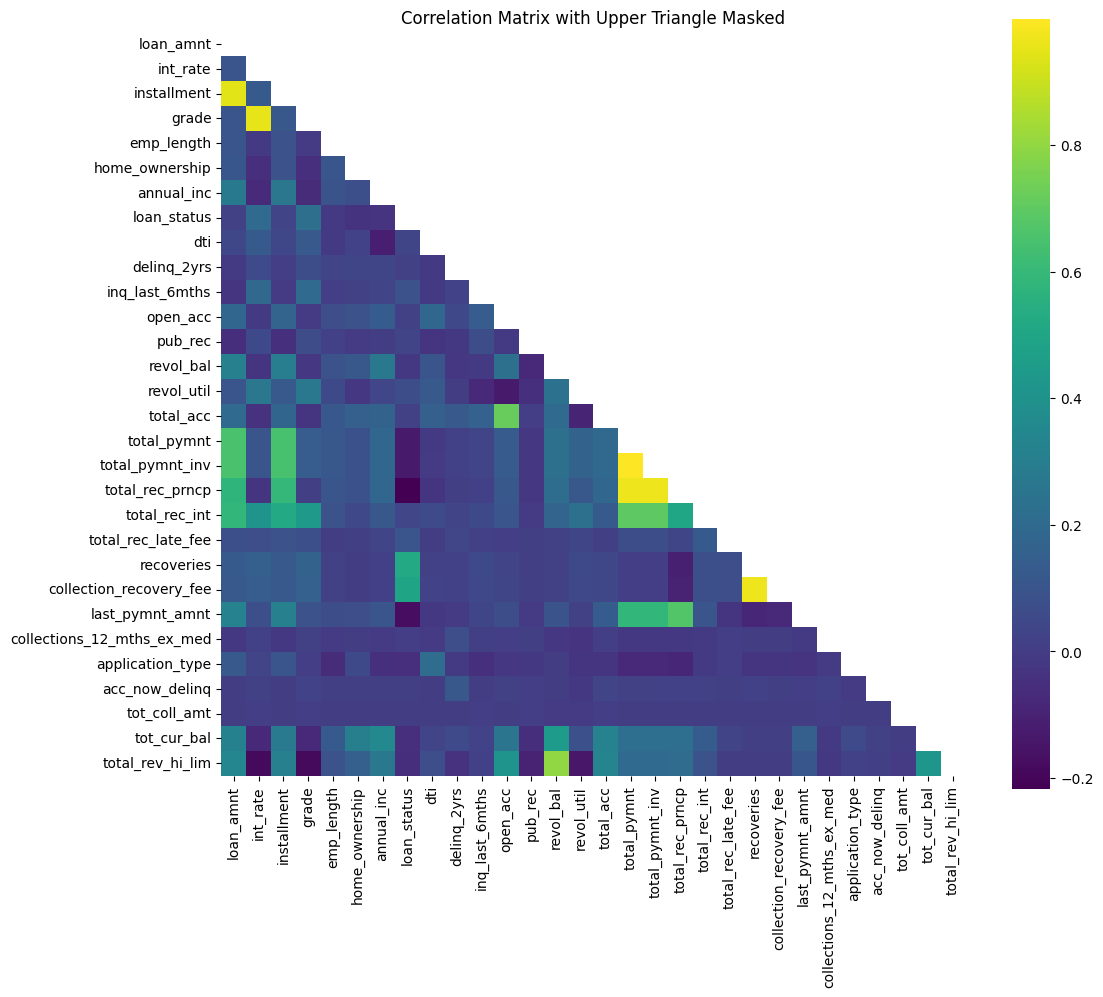


Best 10 features:
Index(['recoveries', 'collection_recovery_fee', 'grade', 'total_rec_prncp',
       'int_rate', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_late_fee', 'inq_last_6mths'],
      dtype='object')


Worst 10 features:
Index(['tot_coll_amt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'emp_length', 'total_acc', 'delinq_2yrs', 'open_acc', 'revol_bal',
       'loan_amnt', 'installment'],
      dtype='object')


In [30]:
# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Create a mask to display only the lower triangle of the correlation matrix
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot the masked heatmap without annotating values in each box
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='viridis', mask=mask, annot=False, square=True)
plt.title("Correlation Matrix with Upper Triangle Masked")
plt.show()

# Get absolute correlations with the target variable 'loan_status'
corr_with_target = corr_matrix['loan_status'].abs()

# Find best 10 features (with high correlation)
best_10_features = corr_with_target.sort_values(ascending=False).head(11).index[1:]

# Find worst 10 features (with low correlation)
worst_10_features = corr_with_target.sort_values().head(10).index

print()
print("Best 10 features:")
print(best_10_features)

print()
print("\nWorst 10 features:")
print(worst_10_features)

In [31]:
# unstacking correlation to check highest correlation pairs
corr_matrix = train_data.corr().abs()
unstack_corr = corr_matrix.unstack()
pairs = unstack_corr.sort_values(ascending=False)

corr_pairs = pd.DataFrame(pairs).drop_duplicates().reset_index()
corr_pairs.columns = ['feature1', 'feature2', 'corr']


# check feature pairs above 0.8 in correlation

cond1 = (corr_pairs.feature1 != corr_pairs.feature2)
cond2 = (corr_pairs['corr']>0.80)

corr_pairs[cond1 & cond2]

,feature1,feature2,corr
1,total_pymnt_inv,total_pymnt,0.999398
2,total_pymnt,total_rec_prncp,0.966959
3,total_pymnt_inv,total_rec_prncp,0.966323
4,recoveries,collection_recovery_fee,0.966294
5,int_rate,grade,0.953059
6,loan_amnt,installment,0.945386


Removing correlated features is important for several reasons:

**Avoiding Multicollinearity:** Highly correlated features can lead to multicollinearity, causing instability in model coefficients and making it difficult to determine the effect of each feature.

**Reducing Overfitting:** Correlated features can cause the model to overfit the training data, capturing noise rather than the underlying pattern, which reduces generalizability to new data.

**Improving Model Performance:** Removing redundant features simplifies the model, leading to faster training times and potentially better performance by focusing on the most informative features.

**Enhancing Interpretability:** A model with fewer, uncorrelated features is easier to interpret and understand, making it clearer how each feature contributes to the predictions.

In [32]:
# Calculate the correlation matrix
corr_matrix = train_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print("Features to drop due to high correlation:")
print(to_drop)

# Drop the features
train_data = train_data.drop(columns=to_drop)
test_data = test_data.drop(columns=to_drop)

print("Data after removing highly correlated features:")
train_data.head()

Features to drop due to high correlation:
['installment', 'grade', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee']
Data after removing highly correlated features:


,loan_amnt,int_rate,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,18600,10.99,6,0,80000.0,0,12.92,0.0,0.0,8.0,...,1355.75,0.0,0.0,15705.09,0.0,0,0.0,0.0,170238.0,20700.0
1,2000,17.97,4,1,55400.0,0,10.62,1.0,2.0,10.0,...,83.95,0.0,0.0,72.28,0.0,1,0.0,74.0,351452.0,10800.0
2,12000,12.29,10,2,60000.0,0,17.92,0.0,0.0,14.0,...,485.96,0.0,0.0,11281.15,0.0,0,0.0,0.0,18207.0,20600.0
3,16000,19.42,7,0,64000.0,0,3.90,1.0,0.0,5.0,...,2303.08,0.0,0.0,589.90,0.0,0,0.0,0.0,12293.0,7800.0
4,22525,16.02,10,1,94080.0,0,19.08,1.0,0.0,15.0,...,2226.12,0.0,0.0,21483.11,0.0,0,0.0,250.0,571244.0,53800.0


## Target Data Balancing

Balancing target variables is crucial for several reasons:

**Improving Model Accuracy:** In an imbalanced dataset, the model may become biased towards the majority class, leading to poor performance on the minority class. Balancing helps the model learn to recognize and correctly predict all classes.

**Avoiding Bias:** An imbalanced dataset can result in a biased model that favors the majority class, potentially ignoring important patterns in the minority class.

**Enhancing Metric Scores:** Balanced datasets improve evaluation metrics such as precision, recall, and F1-score, providing a more accurate measure of the model's performance.

**Ensuring Fairness:** In applications like medical diagnosis or fraud detection, it is essential to accurately predict minority class instances to ensure fair and equitable outcomes.

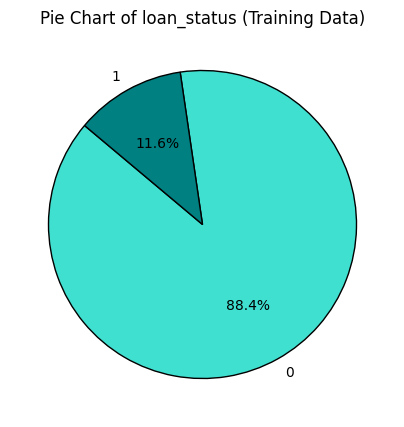

In [33]:
# Plotting the target variable for training data
target = 'loan_status'
class_counts_train = train_data[target].value_counts()

# Define custom colors for training data
colors = ['#40E0D0', '#008080']

# Plot the pie chart for training data
plt.figure(figsize=(5, 5))
plt.pie(class_counts_train, labels=class_counts_train.index, autopct='%1.1f%%', startangle=140, colors=colors[:len(class_counts_train)], wedgeprops={'edgecolor': 'black'})
plt.title('Pie Chart of ' + target + ' (Training Data)')
plt.show()

In [34]:
# Split and Prepare the features and target variable to apply SMOTE
X_train_data = train_data.drop(columns=['loan_status'])
y_train_data = train_data['loan_status']

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_data, y_train_data)

In [35]:
print('Original training data shape is', X_train_data.shape)
print('SMOTE training data shape is', X_train_smote.shape)

Original training data shape is (226067, 24)
SMOTE training data shape is (399810, 24)


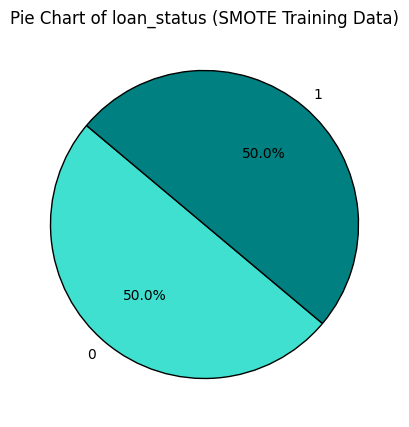

In [36]:
# Plotting the target variable for oversampled training data
target = 'loan_status'
class_counts_smote = pd.Series(y_train_smote).value_counts()

# Define custom colors for oversampled training data
colors = ['#40E0D0', '#008080']

# Plot the pie chart for oversampled training data
plt.figure(figsize=(5, 5))
plt.pie(class_counts_smote, labels=class_counts_smote.index, autopct='%1.1f%%', startangle=140, colors=colors[:len(class_counts_smote)], wedgeprops={'edgecolor': 'black'})
plt.title('Pie Chart of ' + target + ' (SMOTE Training Data)')
plt.show()

The first pie chart shows the imbalanced distribution of the target variable loan_status in the training data, with 88.4% belonging to class 0 and 11.6% to class 1. The second pie chart, after applying SMOTE (Synthetic Minority Over-sampling Technique), illustrates a balanced distribution, with each class representing 50% of the data, ensuring equal representation for more accurate and unbiased model training.

## Handling Outliers

Handling and removing outliers is important for several reasons:

**Improving Model Performance:** Outliers can skew the results of a model, leading to poor performance and inaccurate predictions. Removing outliers helps in creating a more robust model.

**Enhancing Accuracy:** Outliers can distort statistical measures like mean and standard deviation, impacting the accuracy of the data analysis. By handling outliers, we ensure the data accurately reflects the typical patterns.

**Reducing Overfitting:** Outliers can cause the model to overfit the training data, capturing noise instead of the underlying pattern. Removing outliers helps in building a model that generalizes better to new data.

**Ensuring Validity:** Outliers may indicate data entry errors or rare events that don't reflect the population. Removing these ensures the validity and reliability of the dataset.







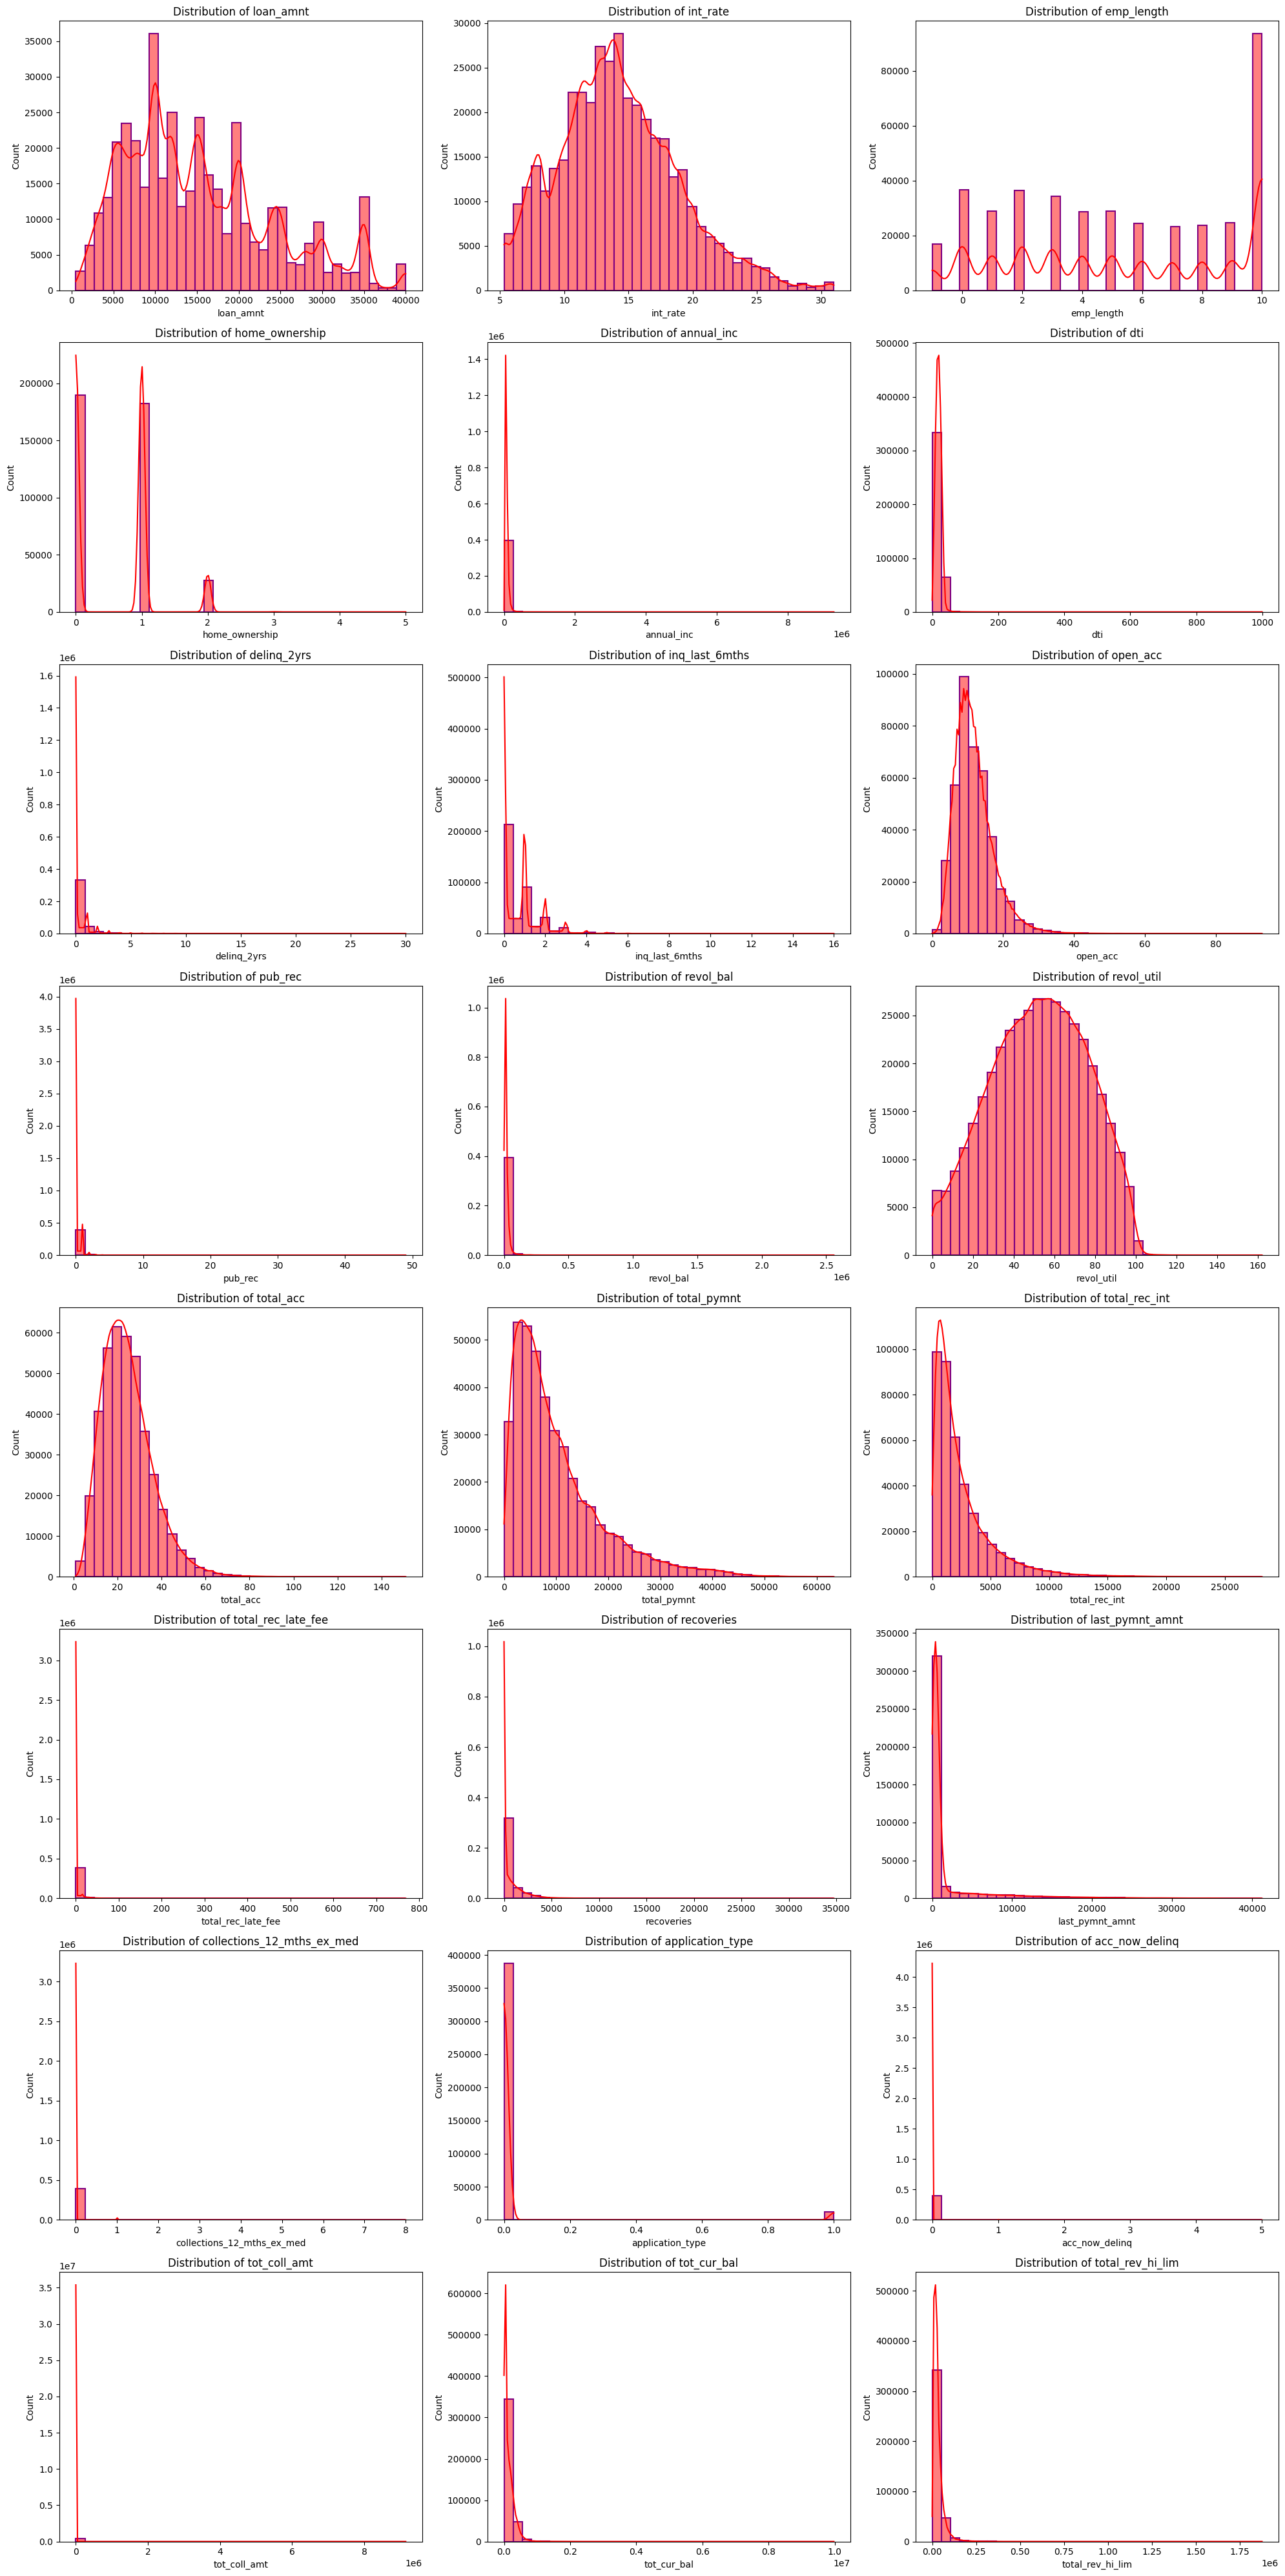

In [37]:
# Columns to plot
columns = X_train_smote.columns.tolist()

# Calculate the number of rows and columns for the subplot grid
n_cols = 3
n_rows = (len(columns) + n_cols - 1) // n_cols

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each column's distribution
for i, column in enumerate(columns):
    sns.histplot(X_train_smote[column], kde=True, color="red", edgecolor="purple", linewidth=1.5, bins=int(180/5), ax=axs[i])
    axs[i].set_title(f'Distribution of {column}')

# Remove empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

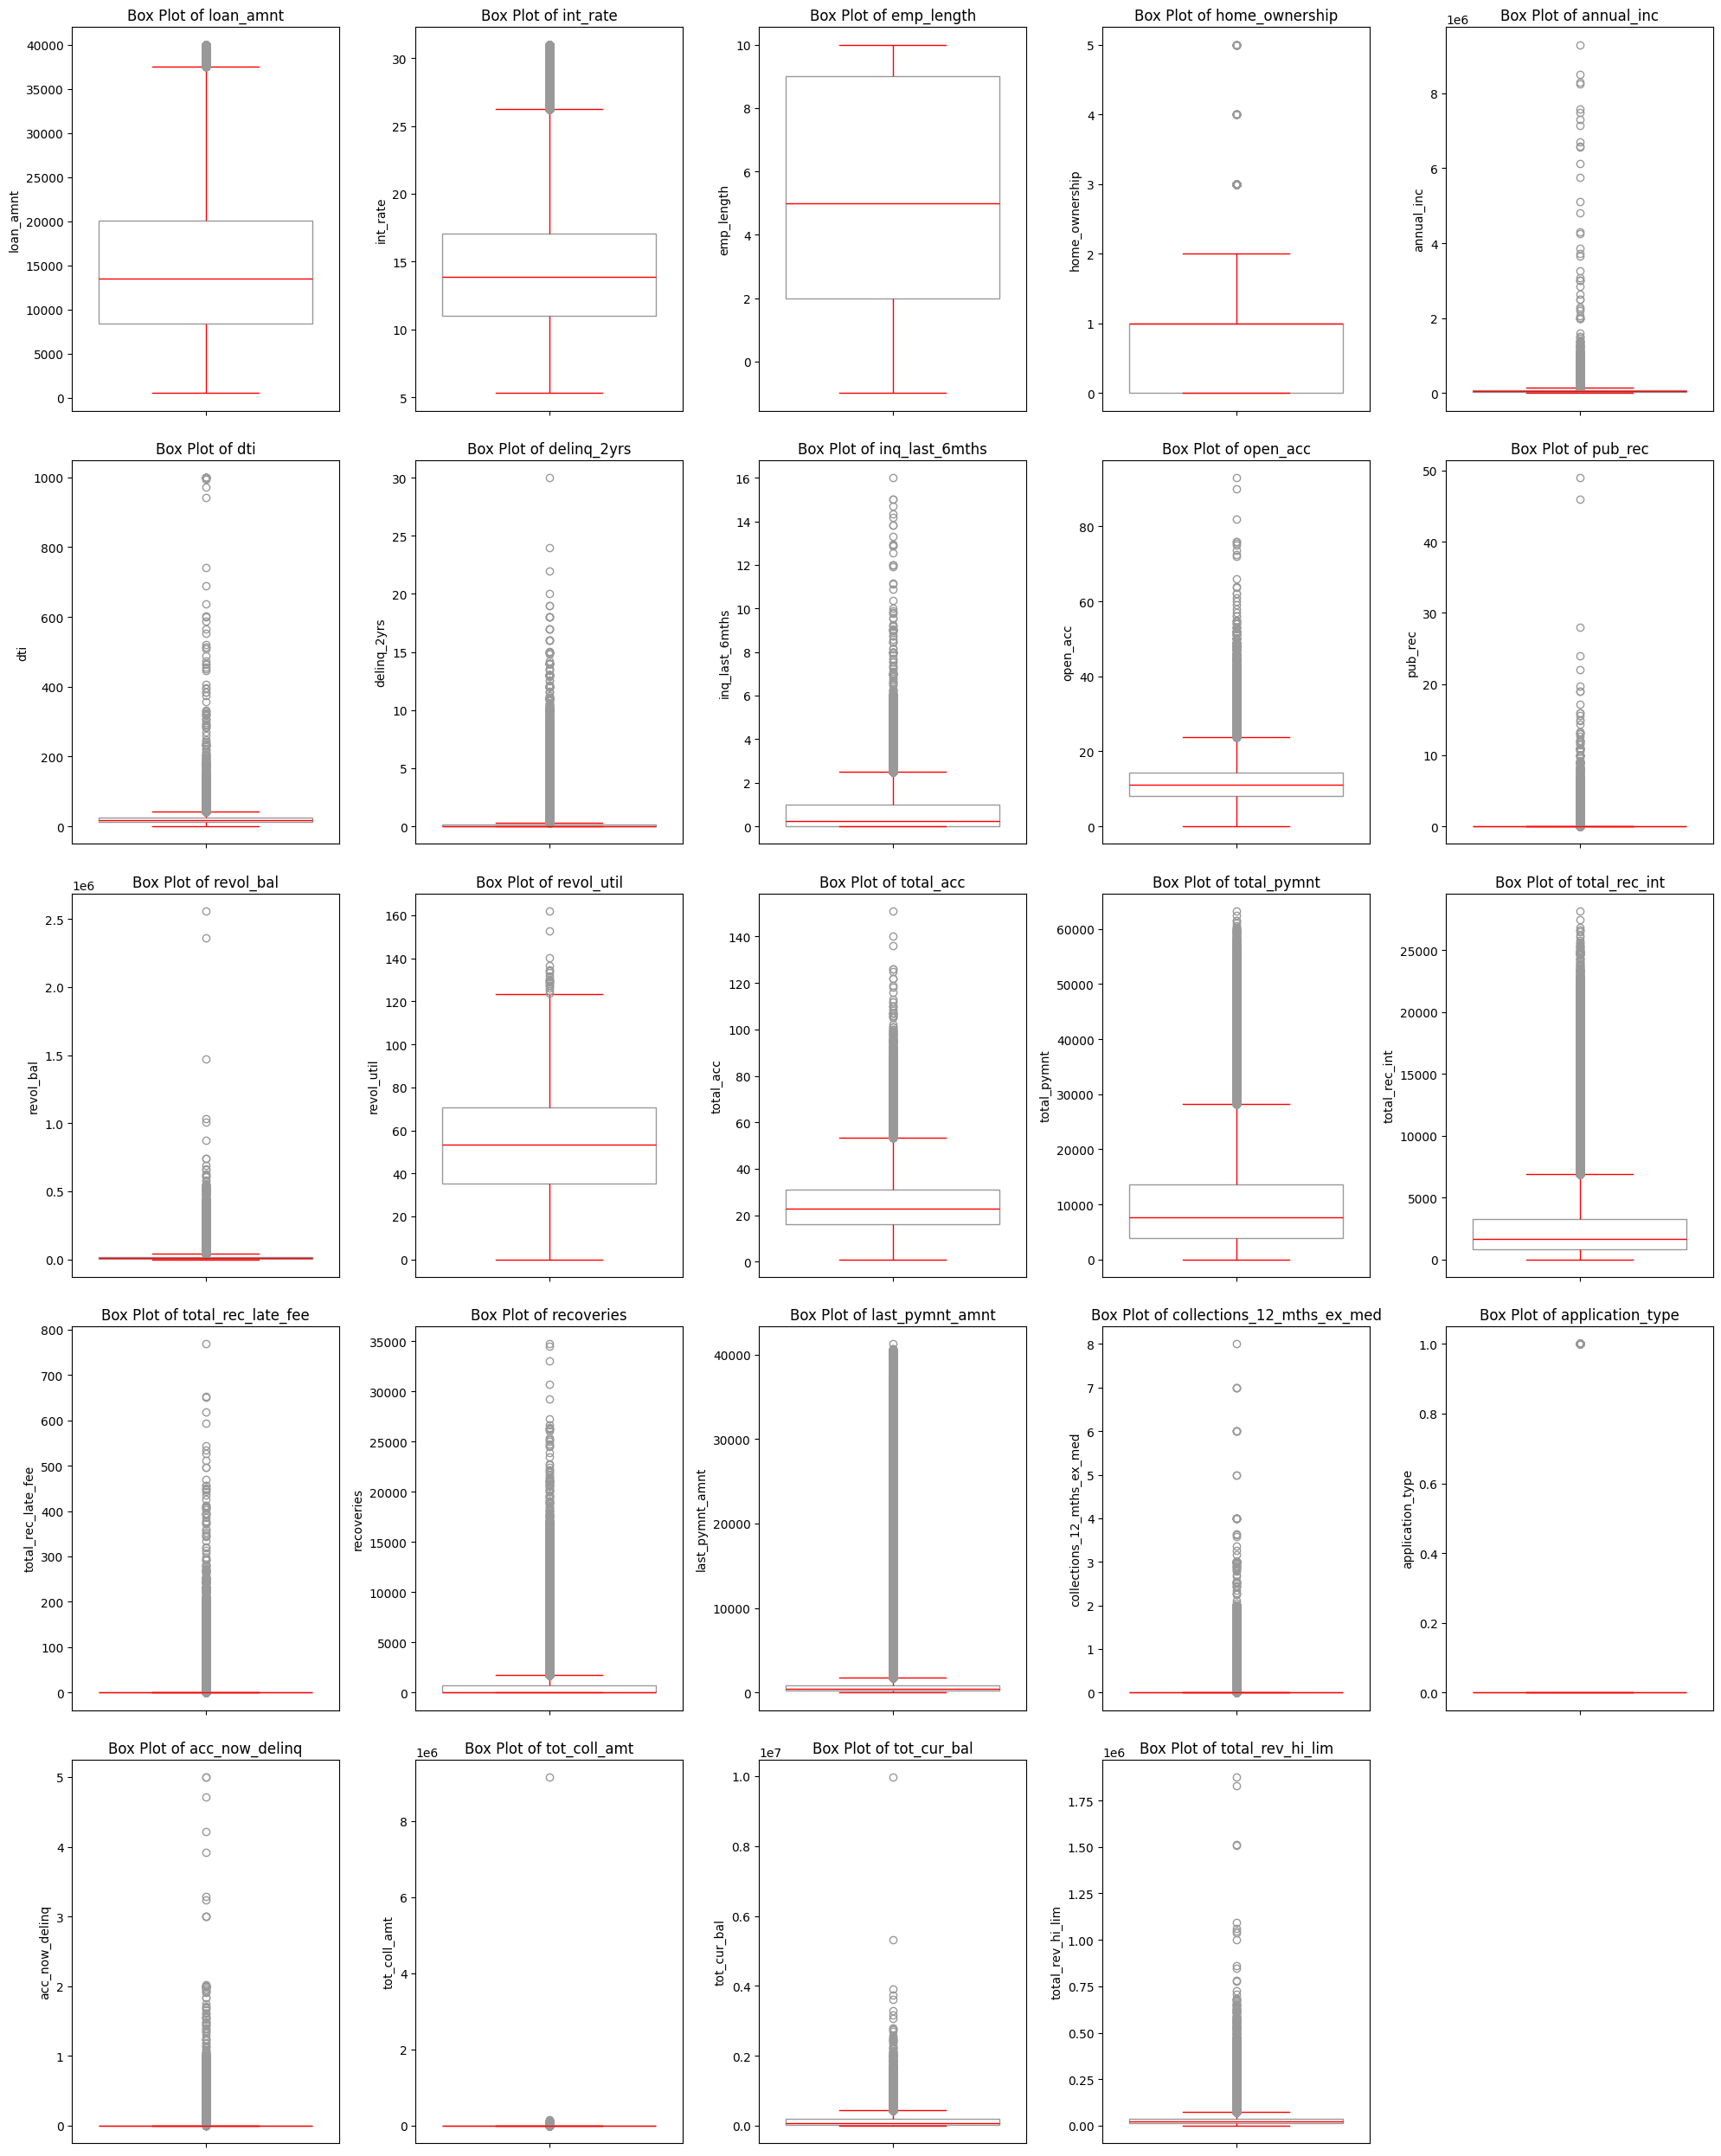

In [38]:
num_columns = len(X_train_smote.columns)
num_rows = (num_columns + 2) // 3  # Adjust the number of rows based on the number of columns

fig, axs = plt.subplots(num_rows, 5, figsize=(20, num_rows * 5))
axs = axs.flatten()

for i, column in enumerate(X_train_smote.columns):
    sns.boxplot(y=X_train_smote[column], ax=axs[i], color='white')
    for patch in axs[i].artists:
        patch.set_edgecolor('red')
        patch.set_facecolor('none')
    for line in axs[i].lines:
        line.set_color('red')
    axs[i].set_title(f'Box Plot of {column}')

# Remove any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [39]:
def remove_outliers_iqr(data):
    print("Skewness of")
    print("Before Removing Outliers")
    for column in data.columns:
        print(f"{column}: {data[column].skew()}")
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + IQR * 1.5
        lower_limit = Q1 - IQR * 1.5
        data[column] = np.where(
            data[column] > upper_limit,
            upper_limit,
            np.where(
                data[column] < lower_limit,
                lower_limit,
                data[column]
            )
        )

    # Checking skewness after removing outliers
    print()
    print("After Removing Outliers")
    for column in data.columns:
        print(f"{column}: {data[column].skew()}")

    return data

X_train_cleaned = remove_outliers_iqr(X_train_smote)
y_train_cleaned = y_train_smote

Skewness of
Before Removing Outliers
loan_amnt: 0.725224270422025
int_rate: 0.4996287157830099
emp_length: -0.0716815557404335
home_ownership: 0.5570775298946965
annual_inc: 47.26747811753437
dti: 28.131182562538672
delinq_2yrs: 5.268713826596637
inq_last_6mths: 1.7942242448175265
open_acc: 1.296302314483473
pub_rec: 8.694990858824317
revol_bal: 16.01628893964691
revol_util: -0.11797747199547591
total_acc: 0.962826957269005
total_pymnt: 1.578061057082361
total_rec_int: 2.3910647948487016
total_rec_late_fee: 12.649207777865461
recoveries: 4.808994044431706
last_pymnt_amnt: 3.690552940076994
collections_12_mths_ex_med: 11.178115812065153
application_type: 5.4067977050047755
acc_now_delinq: 18.889708541487614
tot_coll_amt: 622.336600967971
tot_cur_bal: 3.44217806864022
total_rev_hi_lim: 6.477943363038042

After Removing Outliers
loan_amnt: 0.6916874410153814
int_rate: 0.389129352407221
emp_length: -0.0716815557404335
home_ownership: 0.5305305335137449
annual_inc: 0.8773711595696125
dti: 0

In [40]:
print(X_train_cleaned.shape)
print(y_train_cleaned.shape)

(399810, 24)
(399810,)


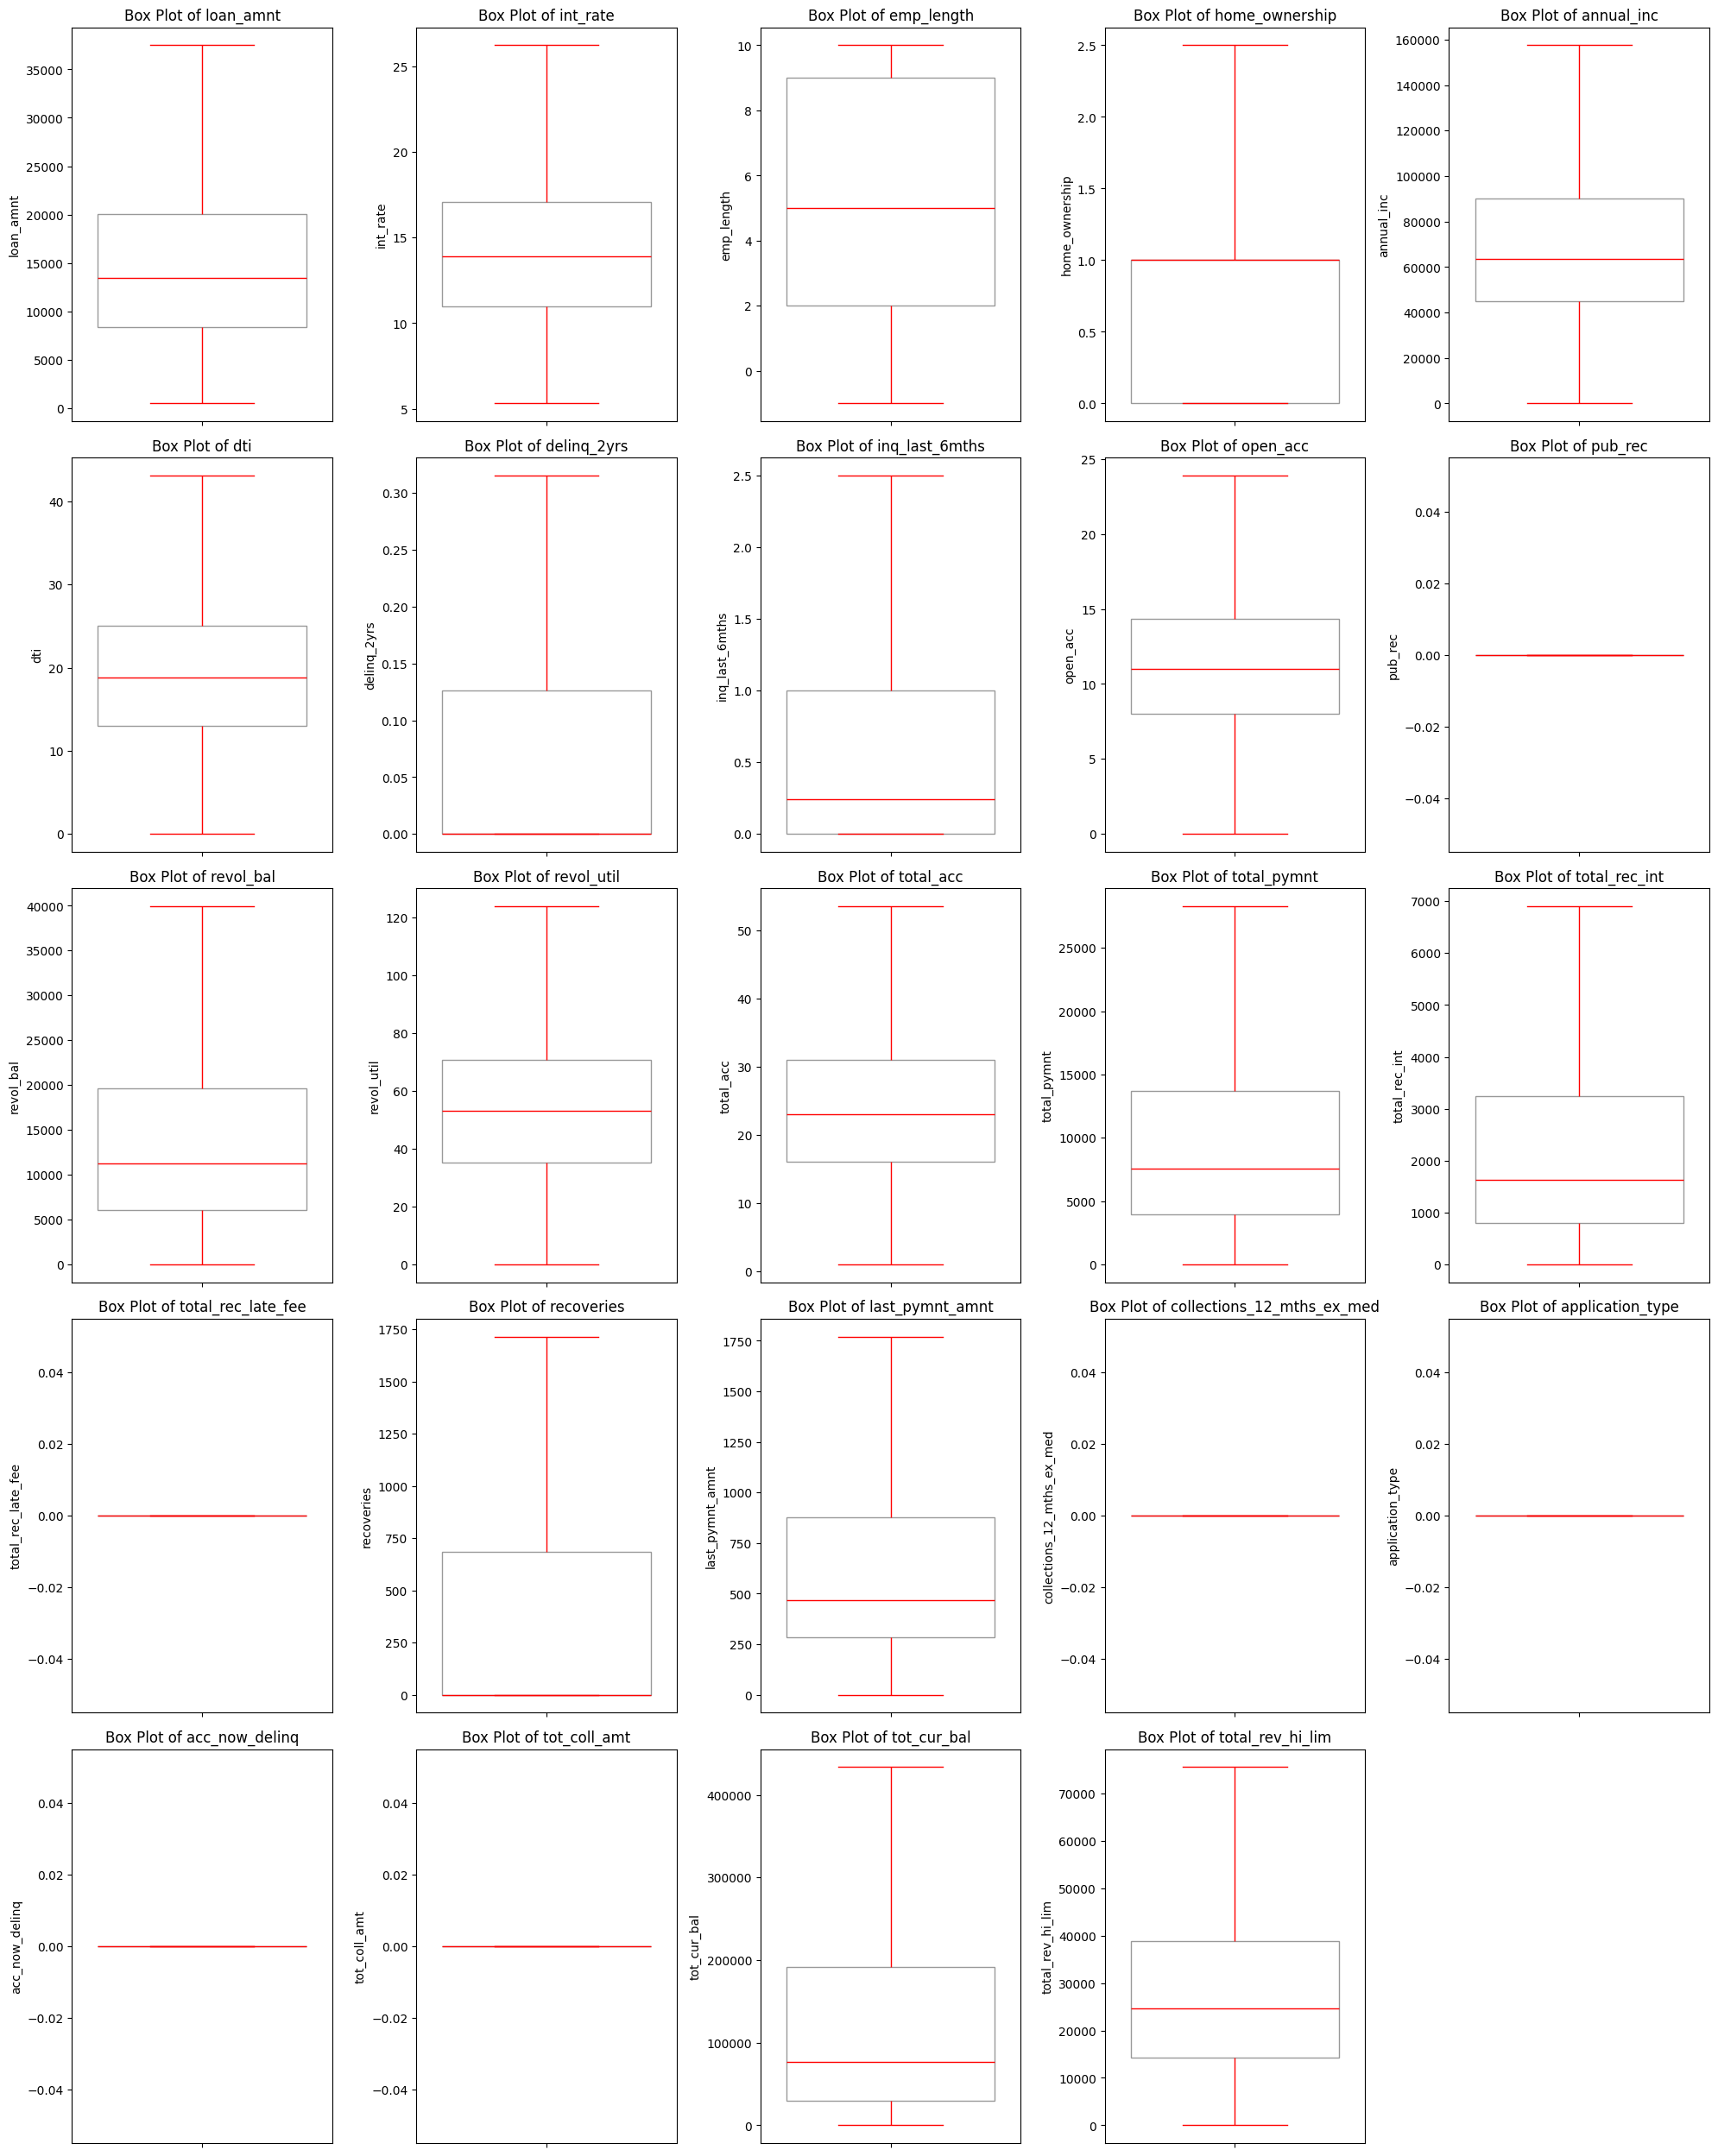

In [41]:
num_columns = len(X_train_cleaned.columns)
num_rows = (num_columns + 2) // 3  # Adjust the number of rows based on the number of columns

fig, axs = plt.subplots(num_rows, 5, figsize=(20, num_rows * 5))
axs = axs.flatten()

for i, column in enumerate(X_train_cleaned.columns):
    sns.boxplot(y=X_train_cleaned[column], ax=axs[i], color='white')
    for patch in axs[i].artists:
        patch.set_edgecolor('red')
        patch.set_facecolor('none')
    for line in axs[i].lines:
        line.set_color('red')
    axs[i].set_title(f'Box Plot of {column}')

# Remove any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


The first set of box plots shows the distribution of various features in the training data before removing outliers, highlighting the presence of significant outliers in multiple columns. The second set of box plots displays the same features after outlier removal, demonstrating a more compact and consistent distribution without extreme values. This process helps improve model performance by reducing the influence of anomalous data points and ensuring a more reliable and robust analysis.

# --***Model Training***--

## Graph Function

In [42]:
def plot_accuracy_chart(title, train_accuracy, test_accuracy):
    # Data for plotting
    datasets = ['Train', 'Test']
    accuracies = [train_accuracy, test_accuracy]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(4, 5))

    # Plot vertical bars with specified width and colors
    bars = ax.bar(datasets, accuracies, color=['#1f77b4', '#ff7f0e'], width=0.4)

    # Add accuracy values on the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

    # Customize the plot
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.ylim(0, 1.1)
    plt.grid(axis='y')
    ax.margins(x=0.3)
    plt.tight_layout()
    plt.show()

In [43]:
def plot_confusion_matrix(title, y_true, y_pred):
    fig, ax = plt.subplots(figsize=(5, 5))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title(title)
    ax.grid(False)
    plt.show()

In [44]:
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc='lower right')
    plt.show()


## Data Preparation

In [45]:
X_train = X_train_cleaned
y_train = y_train_cleaned

X_test = test_data.drop(columns=['loan_status'])
y_test = test_data['loan_status']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(399810, 24)
(399810,)
(226067, 24)
(226067,)


## 1.1 Linear Regression


Mean Squared Error for training data: 0.10870538238361842
Mean Squared Error for testing data: 1.5803061675237287

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88    199905
           1       0.93      0.81      0.87    199905

    accuracy                           0.87    399810
   macro avg       0.88      0.87      0.87    399810
weighted avg       0.88      0.87      0.87    399810

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91    199782
           1       0.42      0.73      0.54     26285

    accuracy                           0.85    226067
   macro avg       0.69      0.80      0.72    226067
weighted avg       0.90      0.85      0.87    226067

Accuracy for training data: 0.8747630124309047
Accuracy for testing data: 0.8528798984371889



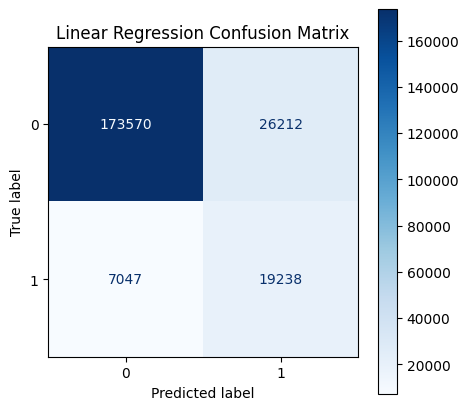

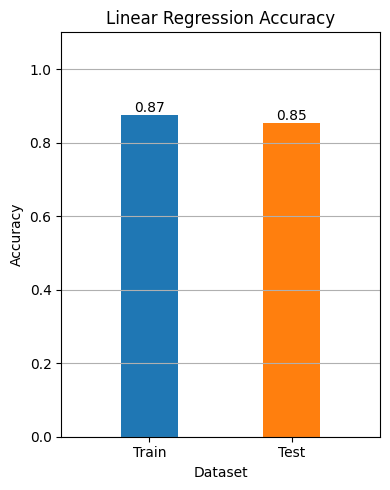

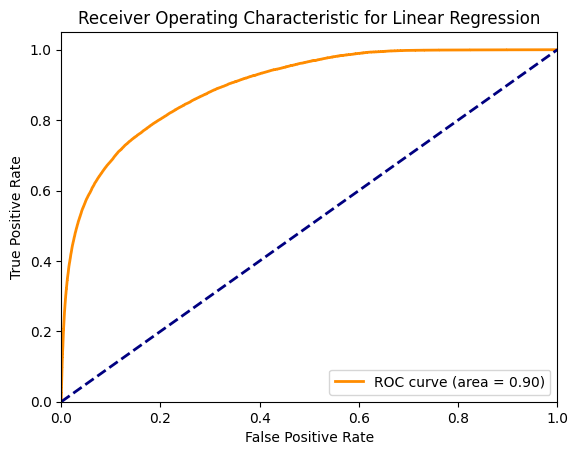

In [46]:
def evaluate_linear_regression(X_train, y_train, X_test, y_test):
    # Standardize the data using RobustScaler
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = lr_model.predict(X_train)
    y_test_pred = lr_model.predict(X_test)

    # Binarize the predictions
    y_train_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_train_pred]
    y_test_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_test_pred]

    # Calculate Mean Squared Error
    mse_train_lr = mean_squared_error(y_train, y_train_pred)
    mse_test_lr = mean_squared_error(y_test, y_test_pred)

    print(f"\nMean Squared Error for training data: {mse_train_lr}")
    print(f"Mean Squared Error for testing data: {mse_test_lr}")

    # Print Classification Report
    classification_report_train = classification_report(y_train, y_train_pred_binary)
    classification_report_test = classification_report(y_test, y_test_pred_binary)
    print("\nClassification Report for Training Data:")
    print(classification_report_train)

    print("Classification Report for Testing Data:")
    print(classification_report_test)

    # Calculate and print accuracy
    accuracy_train_lr = accuracy_score(y_train, y_train_pred_binary)
    accuracy_test_lr = accuracy_score(y_test, y_test_pred_binary)

    print(f"Accuracy for training data: {accuracy_train_lr}")
    print(f"Accuracy for testing data: {accuracy_test_lr}")

    # Confusion Matrix for Linear Regression
    print()
    plot_confusion_matrix('Linear Regression Confusion Matrix', y_test, y_test_pred_binary)

    # Accuracy Comparison graph
    print()
    plot_accuracy_chart('Linear Regression Accuracy', accuracy_train_lr, accuracy_test_lr)

    # Roc Curve
    print()
    plot_roc_curve(y_test, y_test_pred, 'Linear Regression')

    # Collect results
    results = {
        'mse_train': mse_train_lr,
        'mse_test': mse_test_lr,
        'classification_report_train': classification_report_train,
        'classification_report_test': classification_report_test,
        'accuracy_train': accuracy_train_lr,
        'accuracy_test': accuracy_test_lr,
        'y_test_pred_prob': y_test_pred,
    }

    return results

linear_results = evaluate_linear_regression(X_train, y_train, X_test, y_test)

## 1.2 Ridge Regression

Best alpha (lambda): 0.01
Mean Squared Error for the best model on training data: 0.10870538238361856
Mean Squared Error for the best model on testing data: 1.5803062307723295
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88    199905
           1       0.93      0.81      0.87    199905

    accuracy                           0.87    399810
   macro avg       0.88      0.87      0.87    399810
weighted avg       0.88      0.87      0.87    399810

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91    199782
           1       0.42      0.73      0.54     26285

    accuracy                           0.85    226067
   macro avg       0.69      0.80      0.72    226067
weighted avg       0.90      0.85      0.87    226067

Accuracy for training data: 0.8747630124309047
Accuracy for testing data: 0.8528798984371

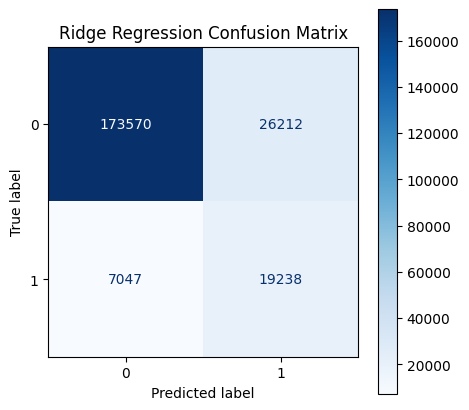

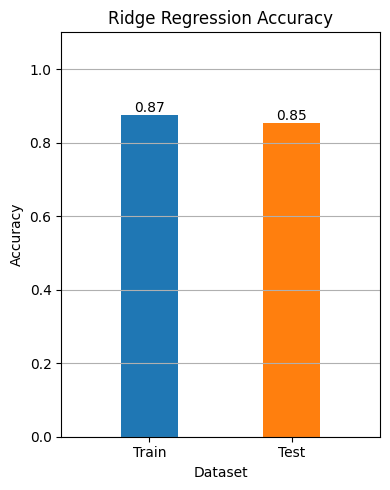

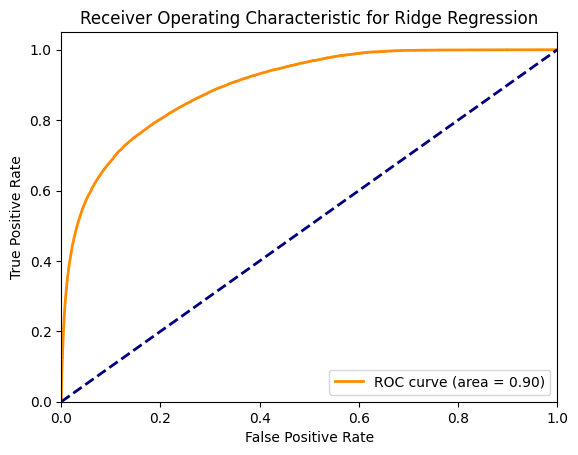

In [47]:
def evaluate_ridge_regression(X_train, y_train, X_test, y_test):
    # Standardize the data using RobustScaler
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize variables to store the best model and lowest MSE
    best_alpha = None
    lowest_mse = float('inf')
    best_model = None
    ridge_results = []

    # Iterate over a range of lambda (alpha) values
    for alpha in np.arange(0.01, 3.01, 0.01):
        # Fit the Ridge Regression model
        ridge_model = Ridge(alpha=alpha)
        ridge_model.fit(X_train, y_train)

        # Make predictions on the training data
        y_train_pred = ridge_model.predict(X_train)

        # Calculate the MSE for the training data
        mse_train = mean_squared_error(y_train, y_train_pred)
        ridge_results.append((alpha, mse_train))

        # Update the best model if the current one is better
        if mse_train < lowest_mse:
            lowest_mse = mse_train
            best_alpha = alpha
            best_model = ridge_model

    # # Uncomment below to Display all lambda results
    # for alpha, mse in ridge_results:
    #     print(f"Alpha: {alpha:.2f}, MSE: {mse}")

    # Make predictions using the best model
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Binarize the predictions
    y_train_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_train_pred]
    y_test_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_test_pred]

    # Calculate Mean Squared Error
    mse_train_ridge = mean_squared_error(y_train, y_train_pred)
    mse_test_ridge = mean_squared_error(y_test, y_test_pred)

    print(f"Best alpha (lambda): {best_alpha}")
    print(f"Mean Squared Error for the best model on training data: {mse_train_ridge}")
    print(f"Mean Squared Error for the best model on testing data: {mse_test_ridge}")

    # Print Classification Report
    print("Classification Report for Training Data:")
    print(classification_report(y_train, y_train_pred_binary))

    print("Classification Report for Testing Data:")
    print(classification_report(y_test, y_test_pred_binary))

    # Calculate and print accuracy
    accuracy_train_ridge = accuracy_score(y_train, y_train_pred_binary)
    accuracy_test_ridge = accuracy_score(y_test, y_test_pred_binary)

    print(f"Accuracy for training data: {accuracy_train_ridge}")
    print(f"Accuracy for testing data: {accuracy_test_ridge}")

    # Confusion Matrix for Ridge Regression
    print()
    plot_confusion_matrix('Ridge Regression Confusion Matrix', y_test, y_test_pred_binary)

    # Accuracy Comparison graph
    print()
    plot_accuracy_chart('Ridge Regression Accuracy', accuracy_train_ridge, accuracy_test_ridge)

    # Roc Curve
    print()
    plot_roc_curve(y_test, y_test_pred, 'Ridge Regression')

    # Collect results
    results = {
        'best_alpha': best_alpha,
        'mse_train': mse_train_ridge,
        'mse_test': mse_test_ridge,
        'classification_report_train': classification_report(y_train, y_train_pred_binary, output_dict=True),
        'classification_report_test': classification_report(y_test, y_test_pred_binary, output_dict=True),
        'accuracy_train': accuracy_train_ridge,
        'accuracy_test': accuracy_test_ridge,
        'y_test_pred_prob': y_test_pred
    }

    return results

ridge_results = evaluate_ridge_regression(X_train, y_train, X_test, y_test)

## 1.3 Lasso Regression


Best alpha (lambda): 0.01
Mean Squared Error for the best model on training data: 0.11147824835165462
Mean Squared Error for the best model on testing data: 1.7596394516402223

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88    199905
           1       0.94      0.78      0.85    199905

    accuracy                           0.87    399810
   macro avg       0.88      0.87      0.87    399810
weighted avg       0.88      0.87      0.87    399810

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93    199782
           1       0.47      0.70      0.56     26285

    accuracy                           0.87    226067
   macro avg       0.71      0.80      0.74    226067
weighted avg       0.90      0.87      0.88    226067

Accuracy for training data: 0.8669317926014857
Accuracy for testing data: 0.87198043058

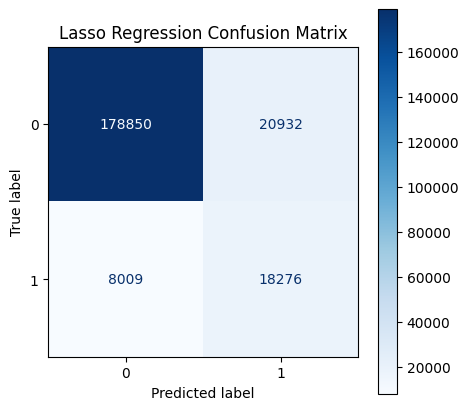

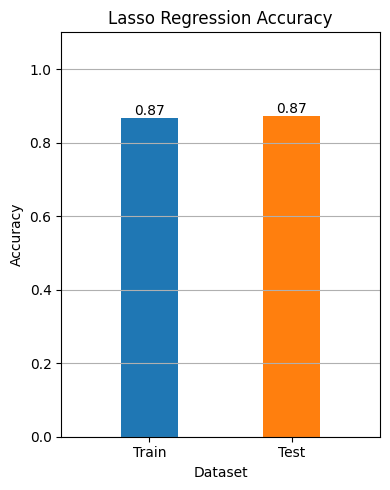

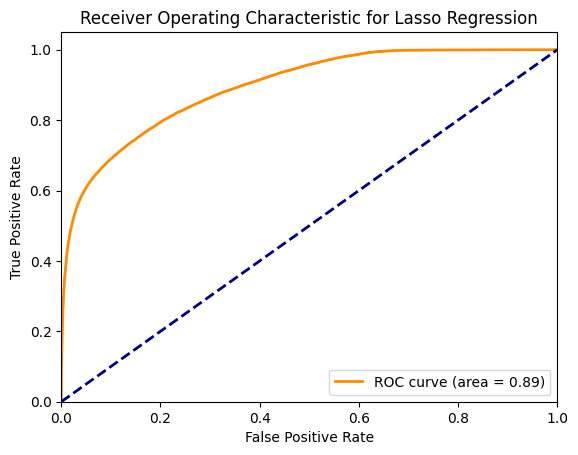

In [48]:
def evaluate_lasso_regression(X_train, y_train, X_test, y_test):
    # Standardize the data using RobustScaler
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize variables to store the best model and lowest MSE
    best_alpha = None
    lowest_mse = float('inf')
    best_model = None
    lasso_results = []

    # Iterate over a range of lambda (alpha) values
    for alpha in np.arange(0.01, 3.01, 0.01):
        # Fit the Lasso Regression model
        lasso_model = Lasso(alpha=alpha)
        lasso_model.fit(X_train, y_train)

        # Make predictions on the training data
        y_train_pred = lasso_model.predict(X_train)

        # Calculate the MSE for the training data
        mse_train = mean_squared_error(y_train, y_train_pred)
        lasso_results.append((alpha, mse_train))

        # Update the best model if the current one is better
        if mse_train < lowest_mse:
            lowest_mse = mse_train
            best_alpha = alpha
            best_model = lasso_model

    # # Uncomment below to Display all lambda results
    # for alpha, mse in lasso_results:
    #     print(f"Alpha: {alpha:.2f}, MSE: {mse}")

    # Make predictions using the best model
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Binarize the predictions
    y_train_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_train_pred]
    y_test_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_test_pred]

    # Calculate Mean Squared Error
    mse_train_lasso = mean_squared_error(y_train, y_train_pred)
    mse_test_lasso = mean_squared_error(y_test, y_test_pred)

    print()
    print(f"Best alpha (lambda): {best_alpha}")
    print(f"Mean Squared Error for the best model on training data: {mse_train_lasso}")
    print(f"Mean Squared Error for the best model on testing data: {mse_test_lasso}")

    # Print Classification Report
    print()
    print("Classification Report for Training Data:")
    print(classification_report(y_train, y_train_pred_binary, zero_division=0))

    print("Classification Report for Testing Data:")
    print(classification_report(y_test, y_test_pred_binary, zero_division=0))

    # Calculate and print accuracy
    accuracy_train_lasso = accuracy_score(y_train, y_train_pred_binary)
    accuracy_test_lasso = accuracy_score(y_test, y_test_pred_binary)

    print(f"Accuracy for training data: {accuracy_train_lasso}")
    print(f"Accuracy for testing data: {accuracy_test_lasso}")

    # Confusion Matrix for Lasso Regression
    print()
    plot_confusion_matrix('Lasso Regression Confusion Matrix', y_test, y_test_pred_binary)

    # Accuracy Comparison graph
    print()
    plot_accuracy_chart('Lasso Regression Accuracy', accuracy_train_lasso, accuracy_test_lasso)

    # Roc Curve
    print()
    plot_roc_curve(y_test, y_test_pred, 'Lasso Regression')

    # Collect results
    results = {
        'best_alpha': best_alpha,
        'mse_train': mse_train_lasso,
        'mse_test': mse_test_lasso,
        'classification_report_train': classification_report(y_train, y_train_pred_binary, zero_division=0, output_dict=True),
        'classification_report_test': classification_report(y_test, y_test_pred_binary, zero_division=0, output_dict=True),
        'accuracy_train': accuracy_train_lasso,
        'accuracy_test': accuracy_test_lasso,
        'y_test_pred_prob': y_test_pred
    }

    return results

lasso_results = evaluate_lasso_regression(X_train, y_train, X_test, y_test)

## 1.4 Random Forest


Mean Squared Error for the Random Forest model on training data: 0.0
Mean Squared Error for the Random Forest model on testing data: 0.03790469197184906

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199905
           1       1.00      1.00      1.00    199905

    accuracy                           1.00    399810
   macro avg       1.00      1.00      1.00    399810
weighted avg       1.00      1.00      1.00    399810

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    199782
           1       0.99      0.68      0.81     26285

    accuracy                           0.96    226067
   macro avg       0.97      0.84      0.89    226067
weighted avg       0.96      0.96      0.96    226067

Accuracy for training data: 1.0
Accuracy for testing data: 0.9620953080281509

Feature Importances:
loan_amnt:

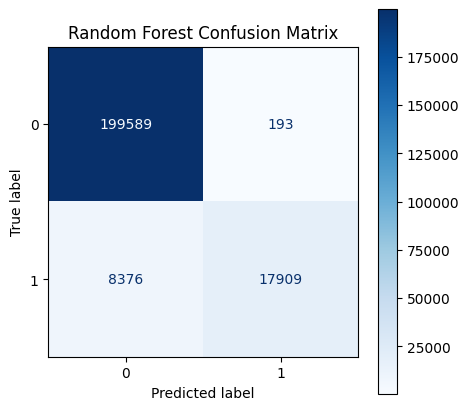

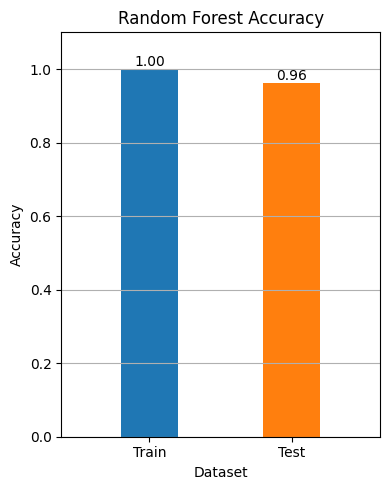

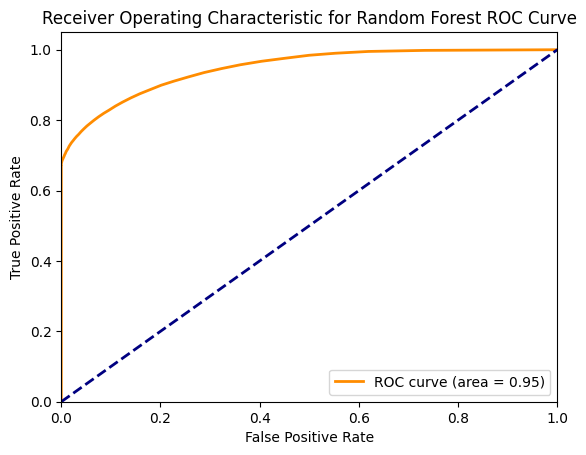

In [49]:
def evaluate_random_forest(X_train, y_train, X_test, y_test):
    # Initialize and fit the Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions using the Random Forest model
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)

    # Calculate Mean Squared Error
    mse_train_rf = mean_squared_error(y_train, y_train_pred)
    mse_test_rf = mean_squared_error(y_test, y_test_pred)

    print()
    print(f"Mean Squared Error for the Random Forest model on training data: {mse_train_rf}")
    print(f"Mean Squared Error for the Random Forest model on testing data: {mse_test_rf}")

    # Print Classification Report
    print()
    print("Classification Report for Training Data:")
    print(classification_report(y_train, y_train_pred))

    print("Classification Report for Testing Data:")
    print(classification_report(y_test, y_test_pred))

    # Calculate and print accuracy
    accuracy_train_rf = accuracy_score(y_train, y_train_pred)
    accuracy_test_rf = accuracy_score(y_test, y_test_pred)

    print(f"Accuracy for training data: {accuracy_train_rf}")
    print(f"Accuracy for testing data: {accuracy_test_rf}")

    # Calculate feature importances
    feature_importances = rf_model.feature_importances_
    feature_names = X_train.columns

    print()
    print("Feature Importances:")
    for feature_name, importance in zip(feature_names, feature_importances):
        print(f"{feature_name}: {importance}")

    # Print the hyperparameters of the final model
    print()
    print('The hyperparameters of the final model are:')
    print(rf_model.get_params())

    # Plot confusion matrix
    print()
    plot_confusion_matrix('Random Forest Confusion Matrix', y_test, y_test_pred)

    # Accuracy Comparison graph
    print()
    plot_accuracy_chart('Random Forest Accuracy', accuracy_train_rf, accuracy_test_rf)

    # Roc Curve
    print()
    plot_roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1], 'Random Forest ROC Curve')

    # Collect results
    results = {
        'mse_train': mse_train_rf,
        'mse_test': mse_test_rf,
        'classification_report_train': classification_report(y_train, y_train_pred, output_dict=True),
        'classification_report_test': classification_report(y_test, y_test_pred, output_dict=True),
        'accuracy_train': accuracy_train_rf,
        'accuracy_test': accuracy_test_rf,
        'feature_importances': dict(zip(feature_names, feature_importances)),
        'hyperparameters': rf_model.get_params(),
        'y_test_pred_prob': y_test_pred
    }

    return results

rf_results = evaluate_random_forest(X_train, y_train, X_test, y_test)

## 1.5 Neural Network

Epoch 1/100
781/781 [==============================] - 6s 5ms/step - loss: 0.3076 - accuracy: 0.8921 - precision: 0.9182 - recall: 0.8609 - auc: 0.9617 - val_loss: 0.4114 - val_accuracy: 0.9498 - val_precision: 0.9343 - val_recall: 0.6117 - val_auc: 0.8815
Epoch 2/100
781/781 [==============================] - 5s 6ms/step - loss: 0.2374 - accuracy: 0.9163 - precision: 0.9587 - recall: 0.8700 - auc: 0.9746 - val_loss: 0.2631 - val_accuracy: 0.9210 - val_precision: 0.6395 - val_recall: 0.7353 - val_auc: 0.9288
Epoch 3/100
781/781 [==============================] - 3s 4ms/step - loss: 0.2266 - accuracy: 0.9187 - precision: 0.9609 - recall: 0.8729 - auc: 0.9759 - val_loss: 0.2563 - val_accuracy: 0.9235 - val_precision: 0.6522 - val_recall: 0.7332 - val_auc: 0.9291
Epoch 4/100
781/781 [==============================] - 3s 4ms/step - loss: 0.2207 - accuracy: 0.9195 - precision: 0.9601 - recall: 0.8754 - auc: 0.9764 - val_loss: 0.2536 - val_accuracy: 0.9236 - val_precision: 0.6549 - val_recal

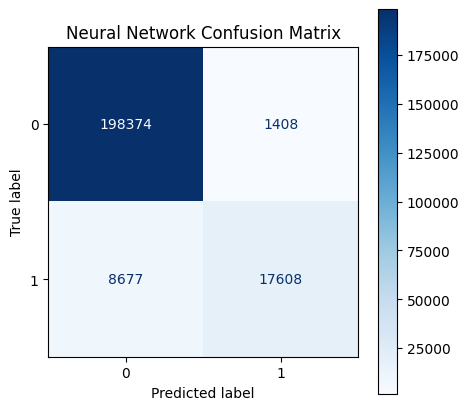

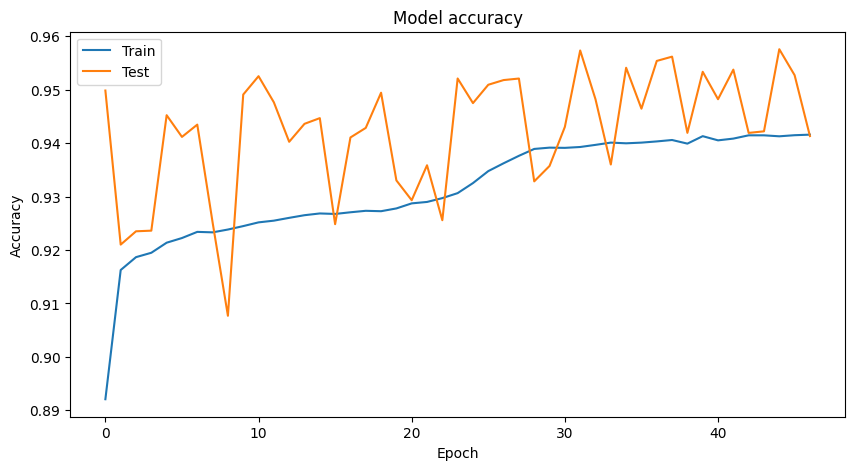

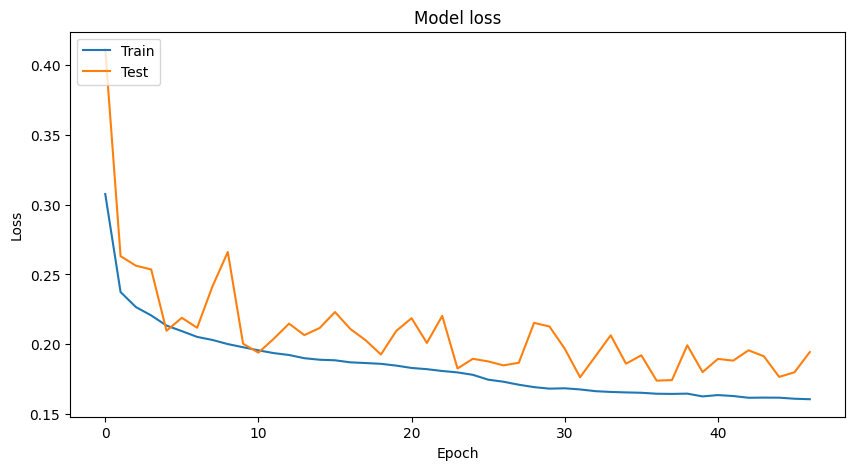

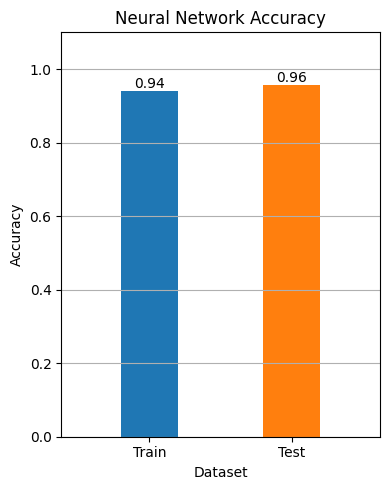

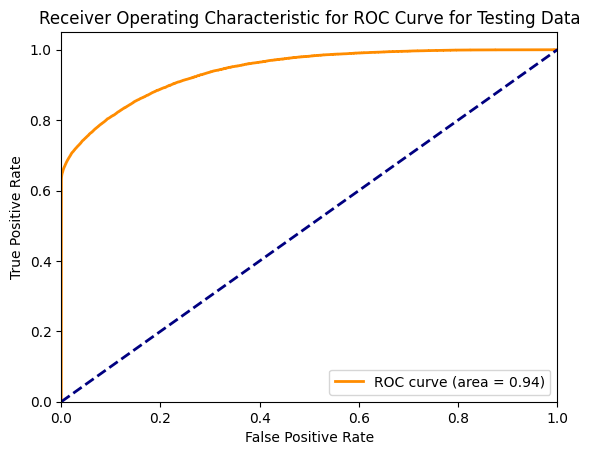

In [50]:
def evaluate_neural_network(X_train, y_train, X_test, y_test):
    # Scale the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Build the Neural Network model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],), name='Input_Layer'))
    model.add(Dense(25, activation='relu', name='Hidden_Layer_1', kernel_regularizer=l2(0.001)))
    model.add(Dense(55, activation='relu', name='Hidden_Layer_2', kernel_regularizer=l2(0.001)))
    model.add(Dense(35, activation='relu', name='Hidden_Layer_3', kernel_regularizer=l2(0.001)))
    model.add(Dense(25, activation='relu', name='Hidden_Layer_4', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', name='Output_Layer'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', Precision(), Recall(), AUC()])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=100,
        batch_size=512,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model
    train_loss, train_accuracy_nn, train_precision, train_recall, train_auc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_accuracy_nn, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test, verbose=0)

    # Calculate F1-score for the test set
    y_test_pred = model.predict(X_test)
    y_test_pred_binary = (y_test_pred > 0.5).astype(int)
    test_f1_score = f1_score(y_test, y_test_pred_binary)

    print()
    print(f"Training Accuracy: {train_accuracy_nn}")
    print(f"Training Precision: {train_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Training AUC: {train_auc}")

    print()
    print(f"Testing Accuracy: {test_accuracy_nn}")
    print(f"Testing Precision: {test_precision}")
    print(f"Testing Recall: {test_recall}")
    print(f"Testing F1-score: {test_f1_score}")
    print(f"Testing AUC: {test_auc}")

    # Print Classification Report
    print()
    print("Classification Report for Training Data:")
    y_train_pred = model.predict(X_train)
    y_train_pred_binary = (y_train_pred > 0.5).astype(int)
    print(classification_report(y_train, y_train_pred_binary, zero_division=0))

    print("Classification Report for Testing Data:")
    print(classification_report(y_test, y_test_pred_binary, zero_division=0))

    # Plot confusion matrix
    print()
    plot_confusion_matrix('Neural Network Confusion Matrix', y_test, y_test_pred_binary)

    # Plot training & validation accuracy values
    print()
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    print()
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Accuracy Comparison graph
    print()
    plot_accuracy_chart('Neural Network Accuracy', train_accuracy_nn, test_accuracy_nn)

    # # ROC Curve for training data
    # print()
    # plot_roc_curve(y_train, y_train_pred, 'ROC Curve for Training Data')

    # ROC Curve for testing data
    print()
    plot_roc_curve(y_test, y_test_pred, 'ROC Curve for Testing Data')

    # Collect results
    results = {
        'accuracy_train': train_accuracy_nn,
        'accuracy_test': test_accuracy_nn,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'test_f1_score': test_f1_score,
        'classification_report_train': classification_report(y_train, y_train_pred_binary, zero_division=0, output_dict=True),
        'classification_report_test': classification_report(y_test, y_test_pred_binary, zero_division=0, output_dict=True),
        'history': history.history,
        'y_test_pred_prob': y_test_pred
    }

    return results

# Example usage:
nn_results = evaluate_neural_network(X_train, y_train, X_test, y_test)

## 1.6 Evaluation

Functions for Comparison and Plotting

In [51]:
def plot_comparison_accuracies(results):
    accuracies_train = [results[model]['accuracy_train'] for model in results]
    accuracies_test = [results[model]['accuracy_test'] for model in results]
    model_names = list(results.keys())

    fig, ax = plt.subplots(figsize=(8, 8))
    index = np.arange(len(model_names))
    bar_width = 0.35

    train_bar = plt.bar(index, accuracies_train, bar_width, label='Train Accuracy', color=['#1f77b4'])
    test_bar = plt.bar(index + bar_width, accuracies_test, bar_width, label='Test Accuracy', color=['#ff7f0e'])

    # Add accuracy values on top of the bars
    for bar in train_bar:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', color='black')

    for bar in test_bar:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', color='black')

    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison Between Models')
    plt.ylim(0, 1.1)
    plt.xticks(index + bar_width / 2, model_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

def compare_classification_reports(results):
    for model in results:
        print(f"Classification Report for {model} - Training Data:")
        print(results[model]['classification_report_train'])
        print(f"\nClassification Report for {model} - Testing Data:")
        print(results[model]['classification_report_test'])
        print("\n" + "="*80 + "\n")

def plot_comparison_roc_curves(results, y_test):
    plt.figure(figsize=(10, 8))
    for model in results:
        y_test_pred_prob = results[model]['y_test_pred_prob']
        fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curves for All Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


Comparison of ROC curves

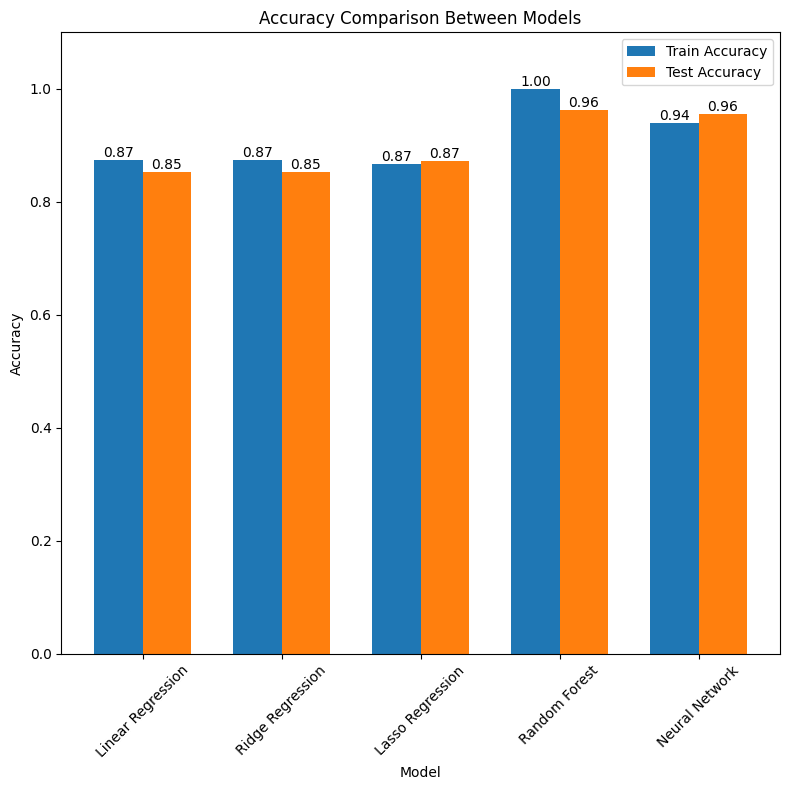

Classification Report for Linear Regression - Training Data:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88    199905
           1       0.93      0.81      0.87    199905

    accuracy                           0.87    399810
   macro avg       0.88      0.87      0.87    399810
weighted avg       0.88      0.87      0.87    399810


Classification Report for Linear Regression - Testing Data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91    199782
           1       0.42      0.73      0.54     26285

    accuracy                           0.85    226067
   macro avg       0.69      0.80      0.72    226067
weighted avg       0.90      0.85      0.87    226067



Classification Report for Ridge Regression - Training Data:
{'0': {'precision': 0.8329348502355346, 'recall': 0.9375803506665666, 'f1-score': 0.8821650879566982, 'support': 199905}, '1': {'precision': 0.9286114766290978, '

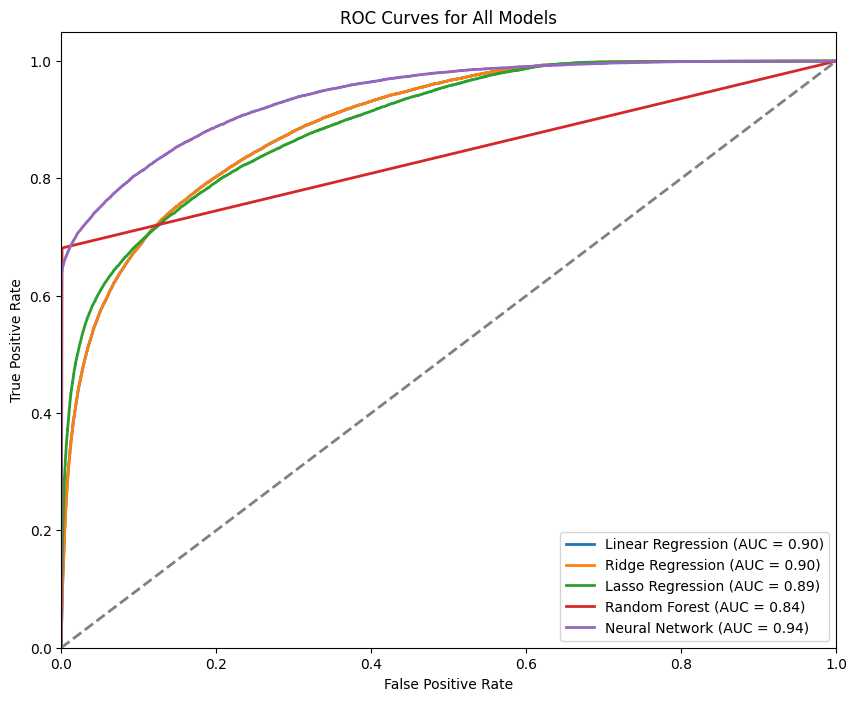

In [52]:
# Example results dictionary (fill with actual results)
results = {
    'Linear Regression': linear_results,
    'Ridge Regression': ridge_results,
    'Lasso Regression': lasso_results,
    'Random Forest': rf_results,
    'Neural Network': nn_results
}

# Separate features and target variable for test data
# y_test = test_data['loan_status']

# Plot and Compare Accuracies
plot_comparison_accuracies(results)

# Compare Classification Reports
compare_classification_reports(results)

# Plot and Compare ROC Curves
plot_comparison_roc_curves(results, y_test)
